In [1]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import random
import time
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # comment this and the following line to use GPUs (if available)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# gym stuff
import gym
import gym_gazebo

# keras stuff
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import action_heatmap

logging_interval = 10
animate_interval = logging_interval * 5
logdir = './turtlebot_dqn_videos/'
model_save_path = './models/'

Using TensorFlow backend.


In [2]:
VISUALIZE = True
SEED = 0
MAX_PATH_LENGTH = 5000
NUM_EPISODES = 1000

# Make the turtlebot-in-empty-world environment
env = gym.make('GazeboEmptyTurtlebotLidarNn-v0')
env.reset()
env._max_episode_steps = MAX_PATH_LENGTH

if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)

np.random.seed(SEED)


Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
Roscore launched!
Gazebo launched!
WARN: Environment '<class 'gym_gazebo.envs.turtlebot.gazebo_empty_turtlebot_lidar_nn.GazeboEmptyTurtlebotLidarNnEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


In [3]:
from collections import namedtuple, deque

class ReplayMemory:
    def __init__(self, capacity = 10000):
        self.memory = deque(maxlen=capacity) # max size for replay buffer
        self.Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))    
    
    def push(self, *args):
        """Saves a transition."""
        self.memory.append(self.Transition(*args))
        
    def sample(self, batch_size):
        if batch_size <= self.__len__():
            return random.sample(self.memory, batch_size)
        else:
            print('Tried to sample more samples than are in buffer')
            return -1

    def __len__(self):
        return len(self.memory)

In [4]:
class QNetwork:
    def __init__(self, state_size, action_size, activation_type, learning_rate, 
                 alpha_decay, gamma, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.alpha_decay = alpha_decay
        self.activation_type = activation_type
        self.gamma = gamma
        self.replay_buffer = ReplayMemory()
        self.batch_size = batch_size
        
    def create_model(self, hidden_layers):
        model = Sequential()
        if len(hidden_layers) == 0:
            model.add(Dense(self.action_size, input_shape=self.state_size, activation="linear"))
        else:
            for i, hid in enumerate(hidden_layers):
                if i == 0:
                    model.add(Dense(hid, input_dim=state_size, activation=self.activation_type))
                else:
                    model.add(Dense(hid, activation=self.activation_type))
            model.add(Dense(action_size, activation='linear'))
        optimizer = Adam(lr=self.learning_rate, decay=self.alpha_decay)
        model.compile(loss='mse', optimizer=optimizer)
        return model
        
    def init_models(self, hidden_layers):
        self.mainDQN = self.create_model(hidden_layers)
        self.targetDQN = self.create_model(hidden_layers)
        self.sync_weights()
    
    def model_descriptions(self):
        print('Main DQN model architecture --->')
        self.mainDQN.summary()
        
        print('Target DQN model architecture --->')
        self.targetDQN.summary()
        
    def sync_weights(self):
        self.targetDQN.set_weights(self.mainDQN.get_weights())
        
    def save_weights(self):
        self.mainDQN.save('./models/turtlebot_dqn_2.h5')
        
    def action_sampler(self, state, exploration_rate):
        if epsilon > np.random.rand():
            # Make a random action
            action = np.random.randint(10, self.action_size)
        else:
            # Get action from Q-network
            Qs = self.mainDQN.predict(state)[0]
            action = np.argmax(Qs)
        return action
    
    def train(self):
        transitions = self.replay_buffer.sample(self.batch_size)
        batch = self.replay_buffer.Transition(*zip(*transitions))
        x_batch = np.squeeze(np.asarray(batch.state))
        y_batch = self.mainDQN.predict(x_batch)
        for i, sample in enumerate(transitions):
            y_batch[i, sample.action] = sample.reward + self.gamma * \
            np.amax(self.targetDQN.predict(sample.next_state)[0]) * (1 - sample.done)
   
        self.sync_weights()
        
        self.mainDQN.fit(x_batch, y_batch, epochs=1, verbose=0)
        
        self.save_weights()
        
               

In [5]:
# transitions = DQN.replay_buffer.sample(32)
# batch = DQN.replay_buffer.Transition(*zip(*transitions))
# # batch = np.asarray(batch)
# print(transitions[0])
# for state, action, reward, next_state, done in transitions:
#     print(action)

In [6]:
#%% Initialize DQN
learning_rate = 0.01
state_size = 2
action_size = 21
activation_type = 'relu'
hidden_size = [100, 100]
alpha_decay = 0.01
gamma = 0.99
batch_size = 64
learn_start = 64

DQN = QNetwork(state_size, action_size, activation_type, learning_rate, alpha_decay, gamma, batch_size)
DQN.init_models(hidden_size)
DQN.model_descriptions()

Main DQN model architecture --->
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 21)                2121      
Total params: 12,521
Trainable params: 12,521
Non-trainable params: 0
_________________________________________________________________
Target DQN model architecture --->
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
____

0.9803966865736877


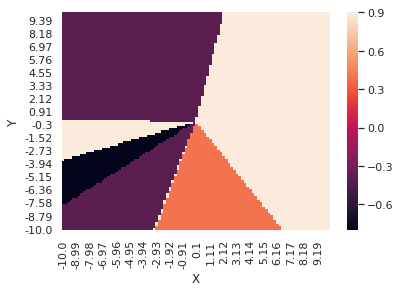

Return recorded for episode1 :  2184.8684023691612
0.9611815447608


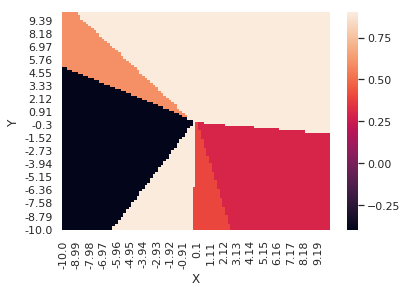

Return recorded for episode2 :  2161.901583861627
0.9423468882484062


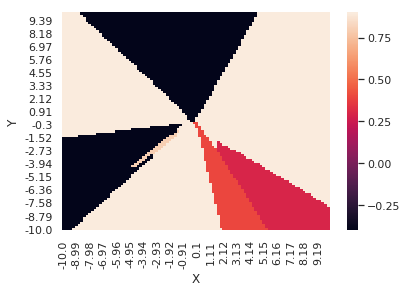

Return recorded for episode3 :  2304.053870201255
0.9238851829227694


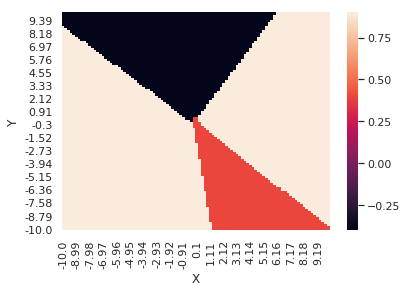

Return recorded for episode4 :  2211.89897524383
0.9057890438555999


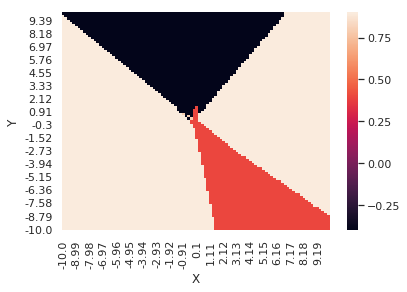

Return recorded for episode5 :  2118.2208822197717
0.888051232349986


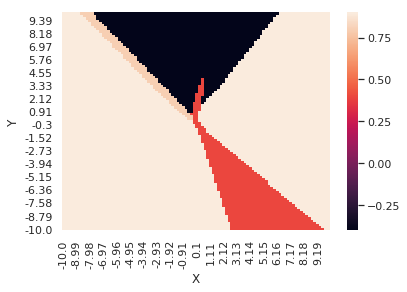

Return recorded for episode6 :  2115.7572546557694
0.8706646530448178


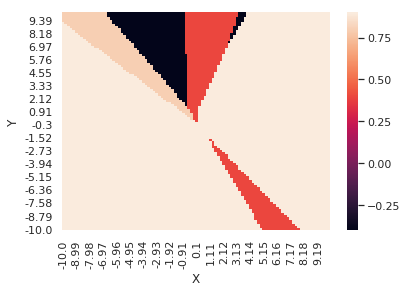

Return recorded for episode7 :  2401.9786235631614
0.8536223510765493


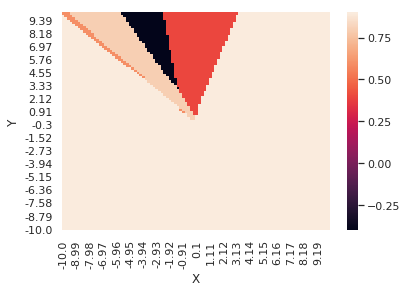

Return recorded for episode8 :  2306.856567636918
0.8369175092971592


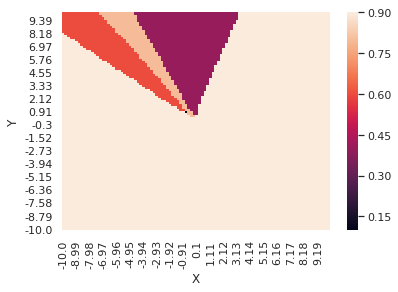

Return recorded for episode9 :  2334.3047389584694
0.820543445547202


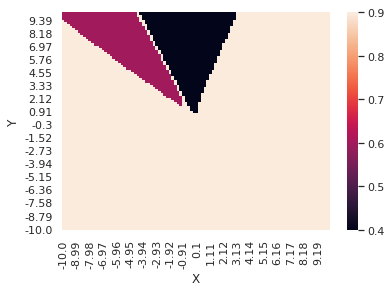

Return recorded for episode10 :  2397.099087221331
Episode -90 ..10   Avg reward: 2013.984089870996   Epsilon: 0.8205
0.8044936099828537


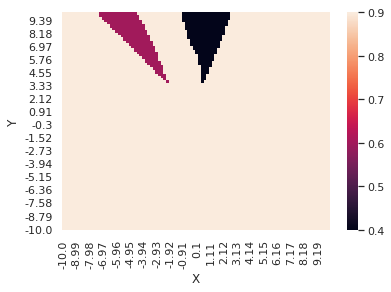

Return recorded for episode11 :  2414.909785486454
0.7887615824558879


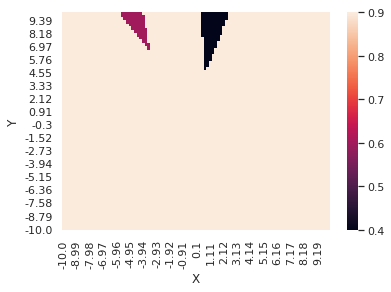

Return recorded for episode12 :  2327.668527004456
0.7733410699455306


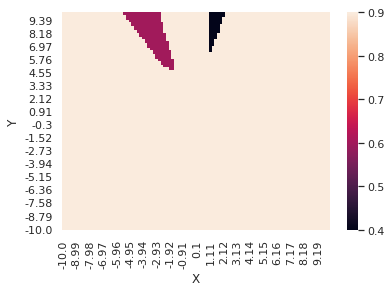

Return recorded for episode13 :  3028.780458001976
0.7582259040411682


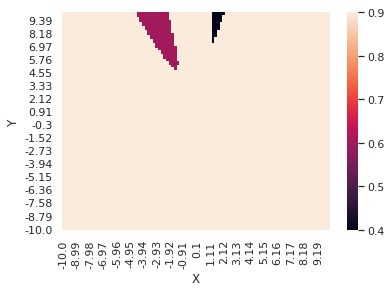

Return recorded for episode14 :  2992.5662675418853
0.7434100384749007


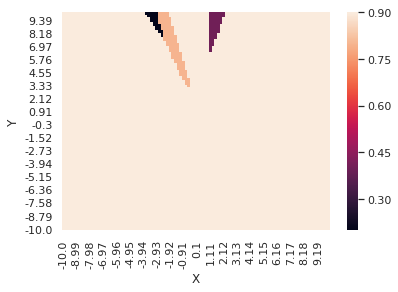

Return recorded for episode15 :  2738.170693000415
0.7288875467029541


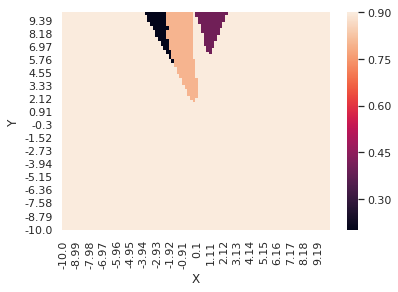

Return recorded for episode16 :  2743.5908044412986
0.7146526195349836


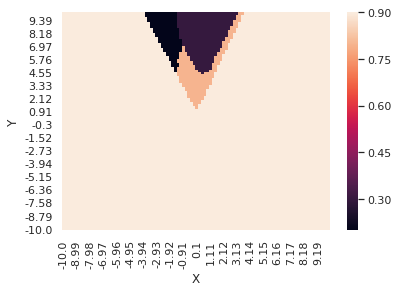

Return recorded for episode17 :  2534.4285228609524
0.7006995628103208


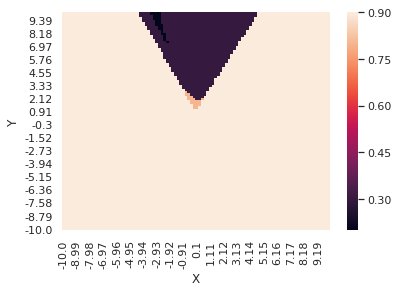

Return recorded for episode18 :  2179.1266671037283
0.6870227951202322


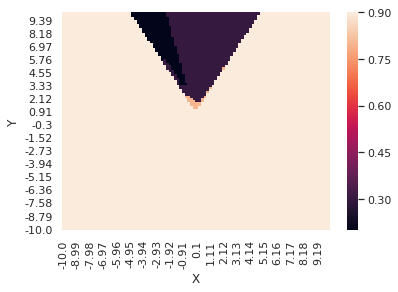

Return recorded for episode19 :  2231.393206277783
0.6736168455752829


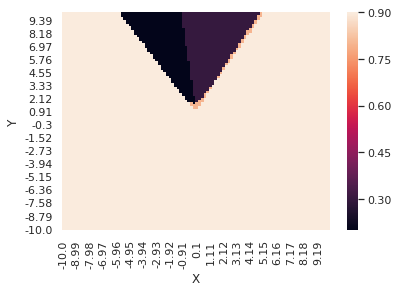

Return recorded for episode20 :  2259.8108910223527
Episode -80 ..20   Avg reward: 2558.7734018940273   Epsilon: 0.6736
0.6604763516169062


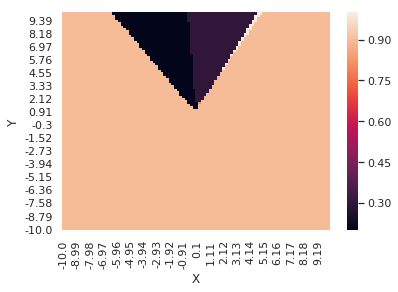

Return recorded for episode21 :  2198.7486433845265
0.64759605687231


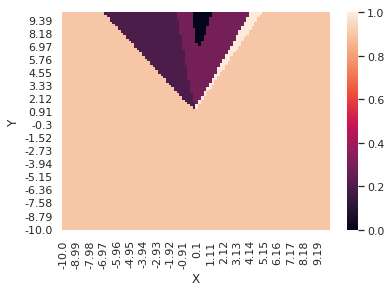

Return recorded for episode22 :  2280.076119206165
0.6349708090518567


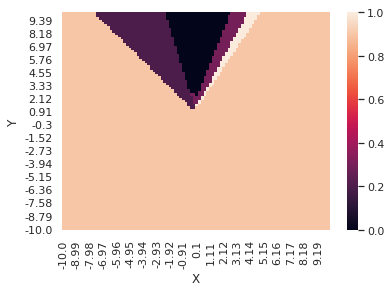

Return recorded for episode23 :  2132.5514369337493
0.6225955578880794


Return recorded for episode24 :  2091.65398681707
0.6104653531155071


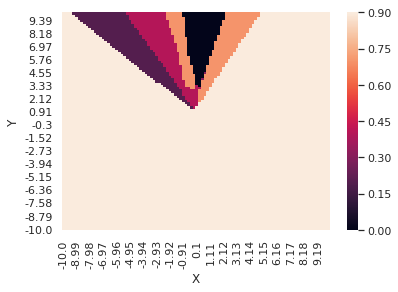

Return recorded for episode25 :  2285.0734856134854
0.5985753424904925


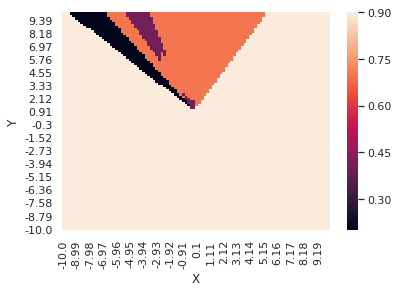

Return recorded for episode26 :  3522.3752324813513
0.5869207698502498


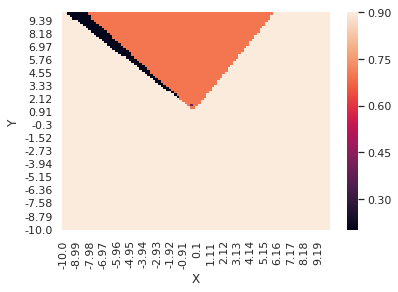

Return recorded for episode27 :  3534.3830588794503
0.5754969732103268


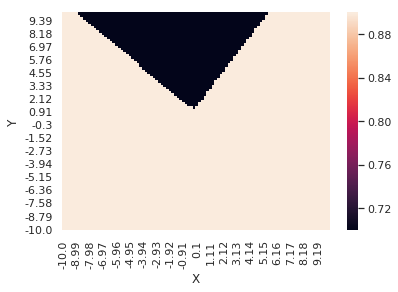

Return recorded for episode28 :  3497.8121055132224
0.564299382899748


Return recorded for episode29 :  3487.6064331671328
0.5533235197330861


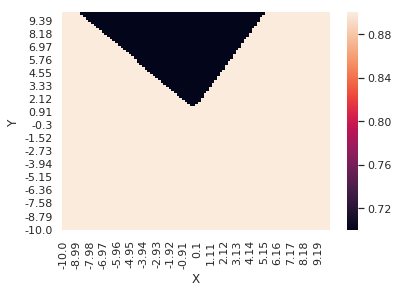

Return recorded for episode30 :  3252.9862149115866
Episode -70 ..30   Avg reward: 2729.0091393018506   Epsilon: 0.5533
0.5425649932187278


Return recorded for episode31 :  3459.666842596466
0.5320194998026181


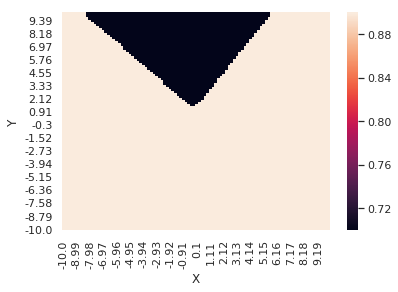

Return recorded for episode32 :  3754.8645383052603
0.5216828211467822


Return recorded for episode33 :  3510.999799186339
0.5115508224419336


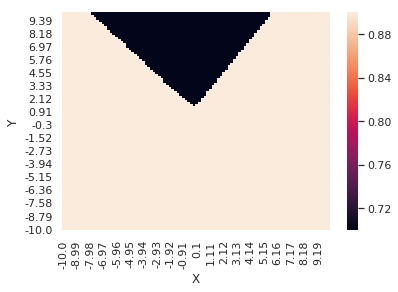

Return recorded for episode34 :  3696.7454816367417
0.5016194507534953


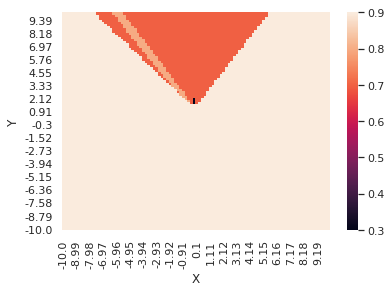

Return recorded for episode35 :  3816.3794305100305
0.491884733400372


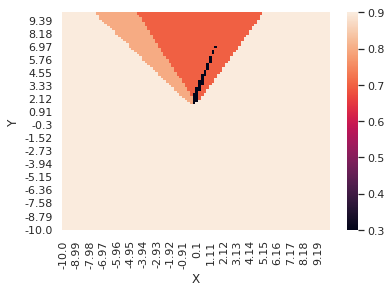

Return recorded for episode36 :  3772.0164724120373
0.48234277636582407


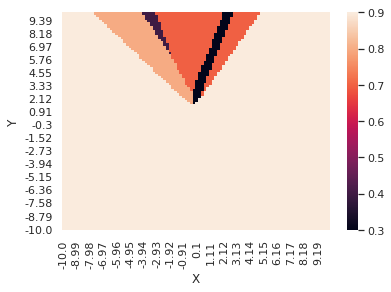

Return recorded for episode37 :  3701.5871538186393
0.47298976273981014


Return recorded for episode38 :  3827.0182546554506
0.4638219511921713


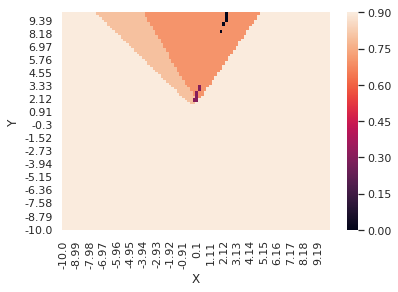

Return recorded for episode39 :  4009.0687259101514
0.45483567447604933


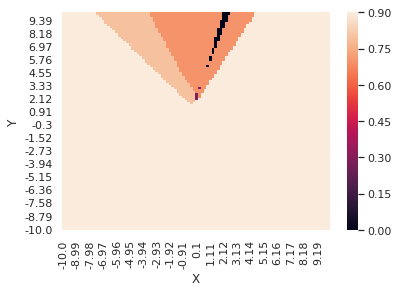

Return recorded for episode40 :  3845.1340084475755
Episode -60 ..40   Avg reward: 3680.1332913942706   Epsilon: 0.4548
0.44602733796093924


Return recorded for episode41 :  3441.8220290225463
0.43739341819478894


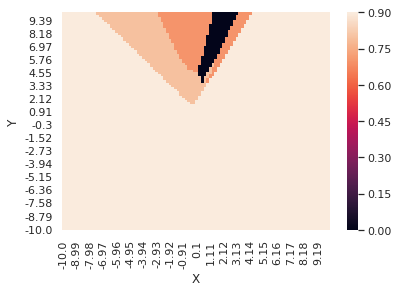

Return recorded for episode42 :  3511.329920068605
0.4289304614945713


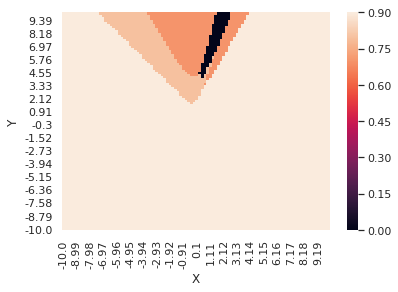

Return recorded for episode43 :  3902.4869363725015
0.42063508256476556


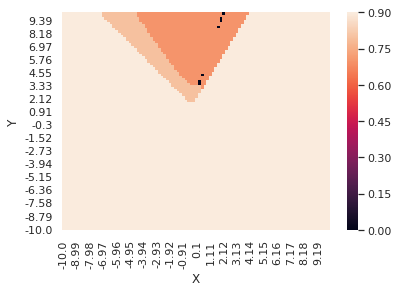

Return recorded for episode44 :  4192.5872442586915
0.4125039631431931


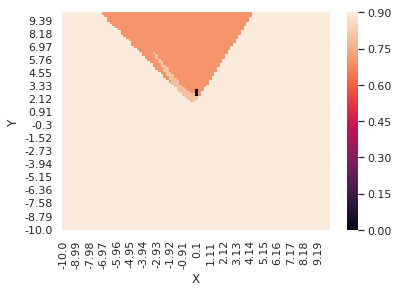

Return recorded for episode45 :  4093.4956359550783
0.404533850673669


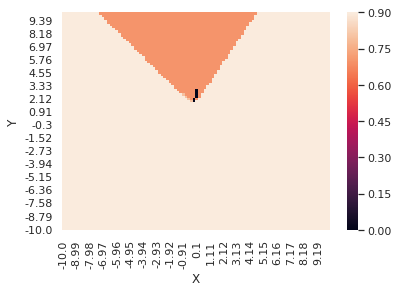

Return recorded for episode46 :  4081.0146159587716
0.3967215570049359


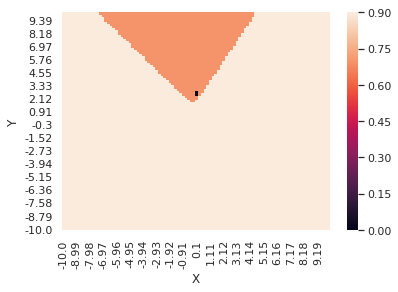

Return recorded for episode47 :  3984.917145600068
0.38906395711536096


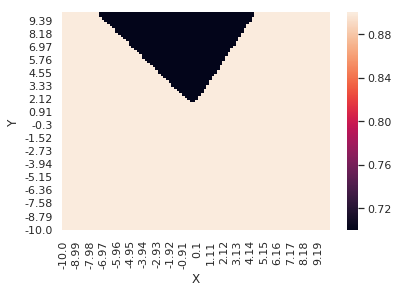

Return recorded for episode48 :  4299.503801934125
0.3815579878628856


Return recorded for episode49 :  4359.380044116702
0.3742006467597279


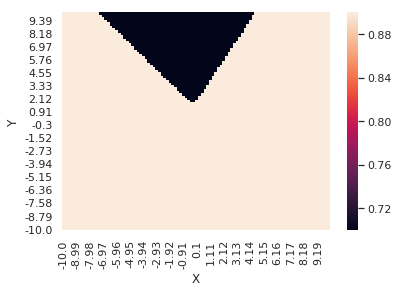

Return recorded for episode50 :  4312.502618874275
Episode -50 ..50   Avg reward: 3971.167138173467   Epsilon: 0.3742
0.3669889907713475


Return recorded for episode51 :  4229.499641310858
0.35992013513919235


Return recorded for episode52 :  4462.6709835379415
0.3529912522267568


Return recorded for episode53 :  4407.535338873361
0.34619957038848975


Return recorded for episode54 :  4276.201794222066
0.3395423728610988


Return recorded for episode55 :  4432.021995973042
0.33301699667680906


Return recorded for episode56 :  4331.440109157543
0.3266208315981408


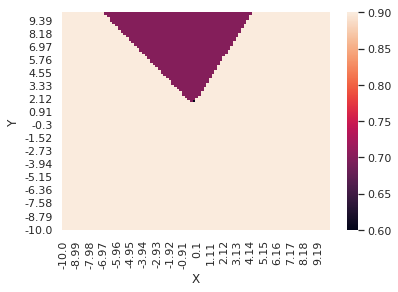

Return recorded for episode57 :  4301.220758022132
0.3203513190737793


Return recorded for episode58 :  4258.723677277263
0.31420595121511996


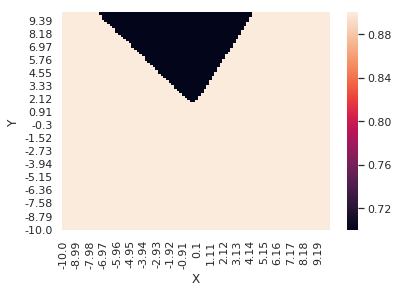

Return recorded for episode59 :  4309.295716225956
0.3081822697930801


Return recorded for episode60 :  4421.573625445181
Episode -40 ..60   Avg reward: 4332.111263347443   Epsilon: 0.3082
0.30227786525477407


Return recorded for episode61 :  4266.864732348421
0.29649037575966014


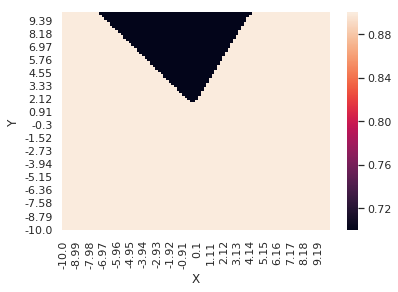

Return recorded for episode62 :  4271.989614672518
0.2908174862347727


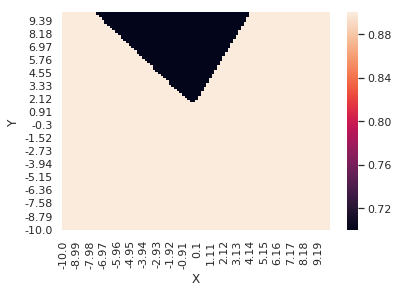

Return recorded for episode63 :  4473.59013084771
0.2852569274486622


Return recorded for episode64 :  4196.640286682701
0.27980647510367246


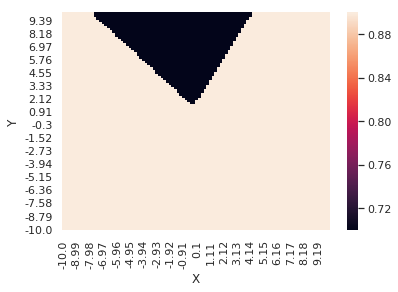

Return recorded for episode65 :  4396.233819829504
0.27446394894619186


Return recorded for episode66 :  4353.190730435049
0.26922721189452276


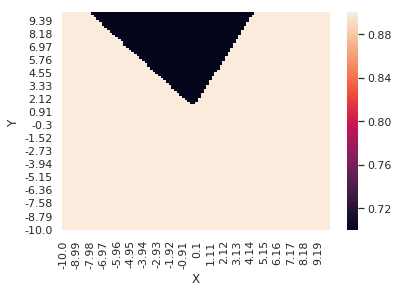

Return recorded for episode67 :  4483.8235287198495
0.26409416918402034


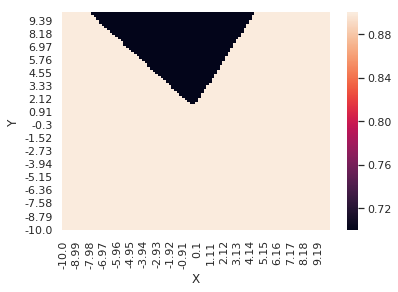

Return recorded for episode68 :  4315.357055072531
0.2590627675291589


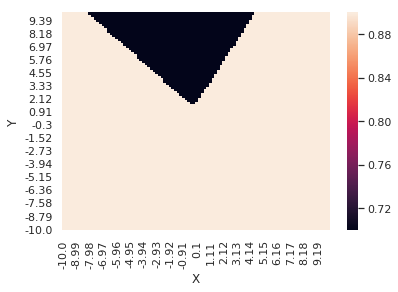

Return recorded for episode69 :  4339.07096909031
0.2541309943021904


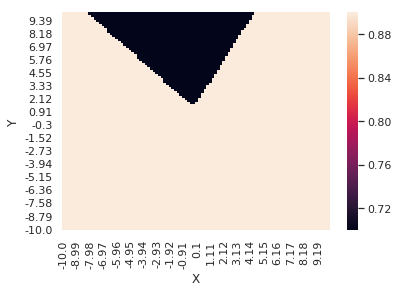

Return recorded for episode70 :  4389.5067015883615
Episode -30 ..70   Avg reward: 4351.833449314377   Epsilon: 0.2541
0.24929687672806608


Return recorded for episode71 :  4477.157931141461
0.24455848109530054


Return recorded for episode72 :  4481.388294479793
0.23991391198246126


Return recorded for episode73 :  4333.0590111592455
0.2353613114999746


Return recorded for episode74 :  4482.100146220482
0.23089885854694553


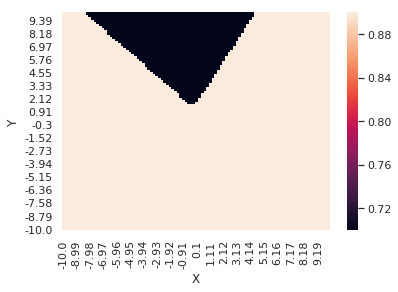

Return recorded for episode75 :  4502.222135343716
0.22652476808269262


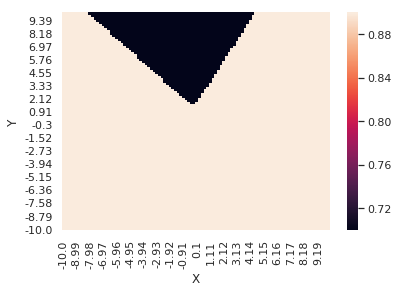

Return recorded for episode76 :  4605.790947336698
0.22223729041270818


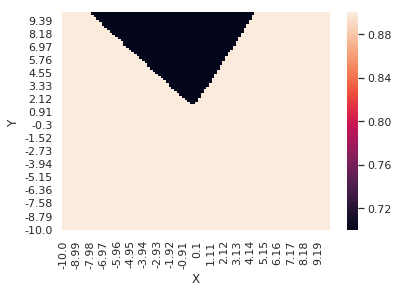

Return recorded for episode77 :  4447.426207153683
0.21803471048875708


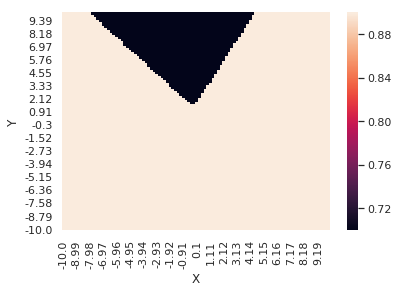

Return recorded for episode78 :  4453.971071103537
0.21391534722283462


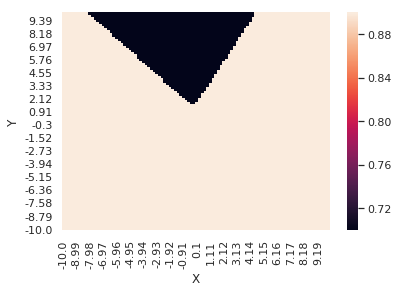

Return recorded for episode79 :  4328.601180350054
0.20987755281470882


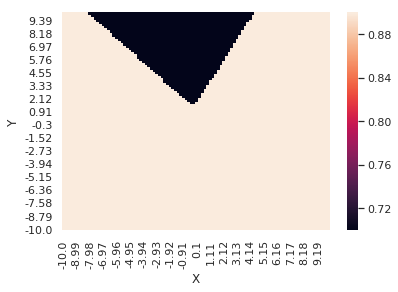

Return recorded for episode80 :  4524.491439064013
Episode -20 ..80   Avg reward: 4450.122362587703   Epsilon: 0.2099
0.2059197120927785


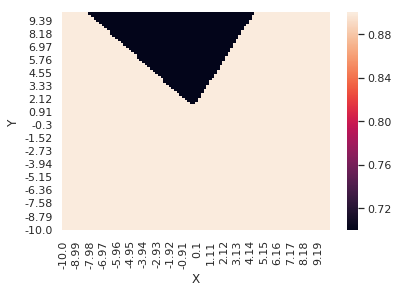

Return recorded for episode81 :  4529.065543358995
0.20204024186798297


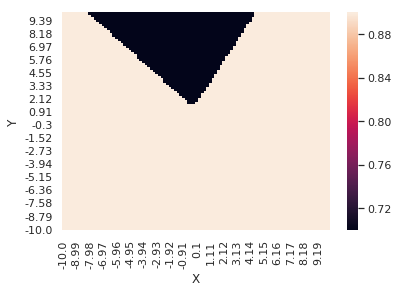

Return recorded for episode82 :  4439.604174317582
0.1982375903005053


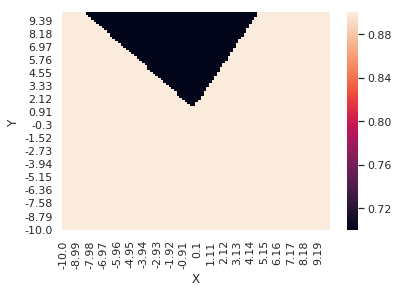

Return recorded for episode83 :  4519.63355449088
0.19451023627901587


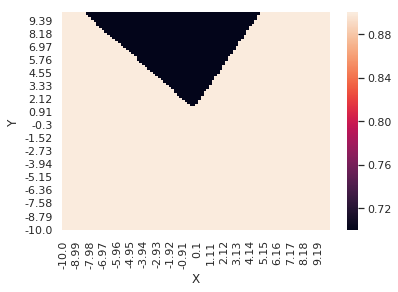

Return recorded for episode84 :  4508.675002312671
0.19085668881220733


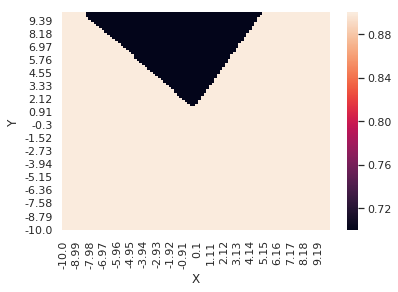

Return recorded for episode85 :  4450.655943022123
0.1872754864323783


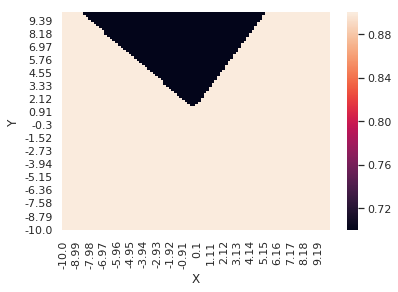

Return recorded for episode86 :  4416.872555473197
0.1837651966108269


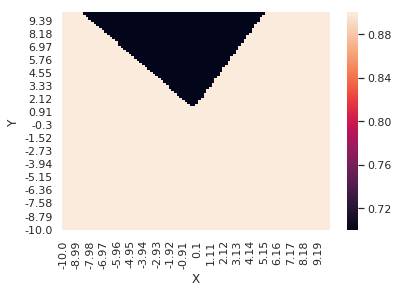

Return recorded for episode87 :  4470.3668363915585
0.18032441518482004


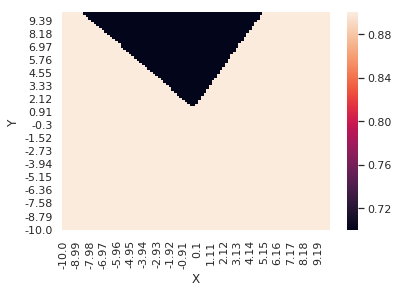

Return recorded for episode88 :  4436.937965431161
0.17695176579590954


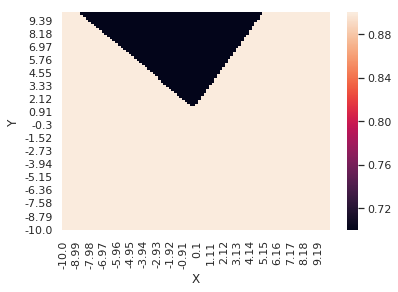

Return recorded for episode89 :  4427.705494637695
0.17364589933937066


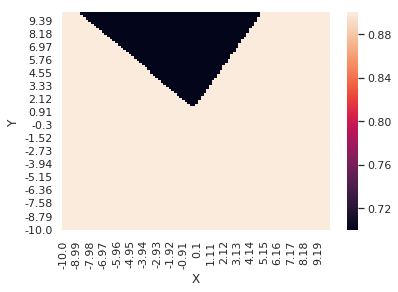

Return recorded for episode90 :  4549.08950941373
Episode -10 ..90   Avg reward: 4472.400850849988   Epsilon: 0.1736
0.17040549342454195


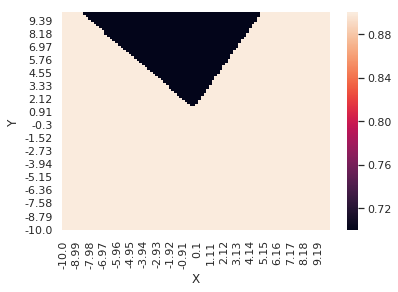

Return recorded for episode91 :  4466.210486835691
0.16722925184585147


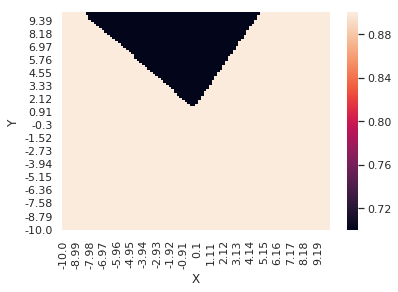

Return recorded for episode92 :  4571.067113682739
0.16411590406431734


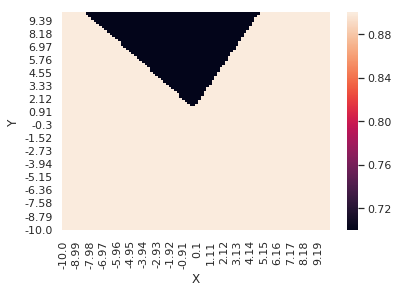

Return recorded for episode93 :  4612.336752784729
0.16106420469931504


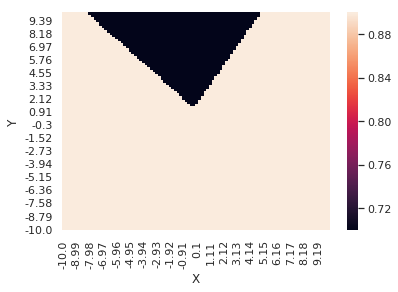

Return recorded for episode94 :  4523.575997790974
0.1580729330304087


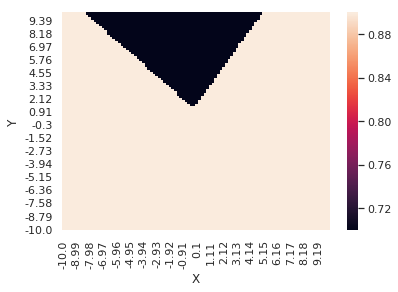

Return recorded for episode95 :  4540.935754088254
0.15514089250904667


Return recorded for episode96 :  4411.114513597314
0.1522669102799259


Return recorded for episode97 :  4385.576143048847
0.14944983671183457


Return recorded for episode98 :  4420.495767050292
0.1466885449377839


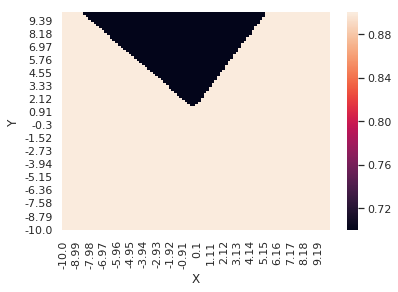

Return recorded for episode99 :  4309.750969359591
0.1439819304042466


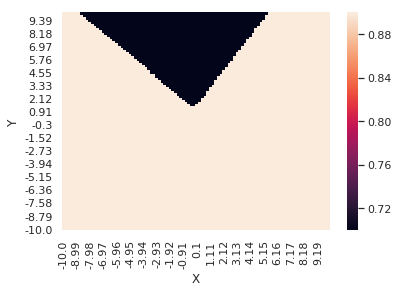

Return recorded for episode100 :  4455.6830093888175
Episode 0 ..100   Avg reward: 4479.015300765216   Epsilon: 0.1440
0.1413289104293205


Return recorded for episode101 :  4430.14570264477
0.13872842376964165


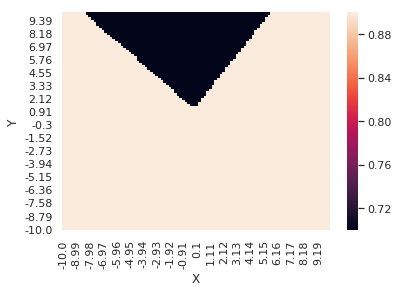

Return recorded for episode102 :  4549.3336249883
0.13617943019587256


Return recorded for episode103 :  4416.1999307509195
0.13368091007659658


Return recorded for episode104 :  4407.027550387456
0.13123186397045208


Return recorded for episode105 :  4309.295338682016
0.12883131222634217


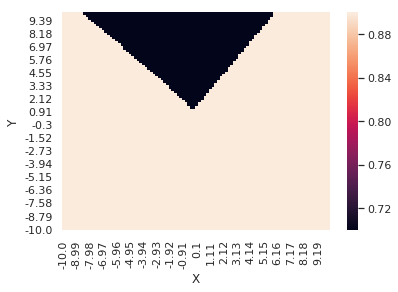

Return recorded for episode106 :  4492.554764275806
0.1264782945915614


Return recorded for episode107 :  4405.282139724256
0.12417186982768189


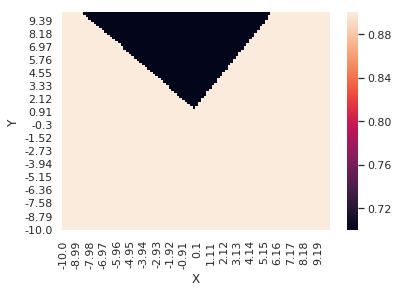

Return recorded for episode108 :  4491.968486438357
0.12191111533404535


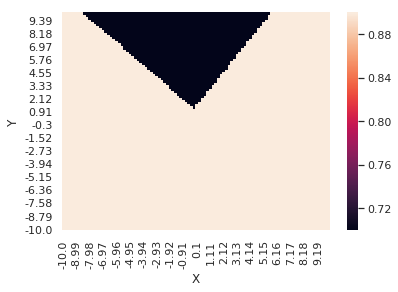

Return recorded for episode109 :  4409.960061655545
0.11969512677871053


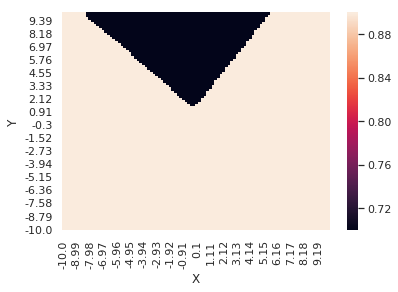

Return recorded for episode110 :  4454.250786074172
Episode 10 ..110   Avg reward: 4436.745060893625   Epsilon: 0.1197
0.11752301773670837


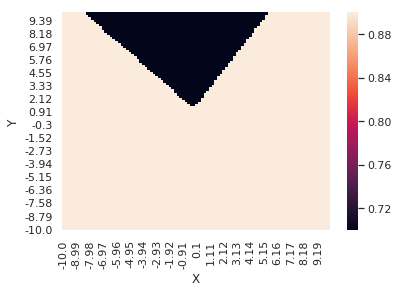

Return recorded for episode111 :  4445.881737903718
0.11539391933546027


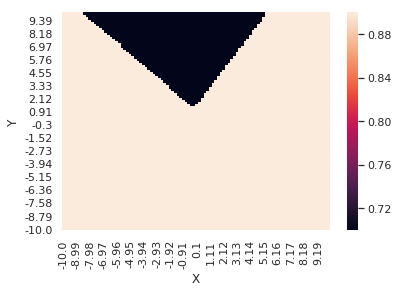

Return recorded for episode112 :  4420.4743946558965
0.11330697990721733


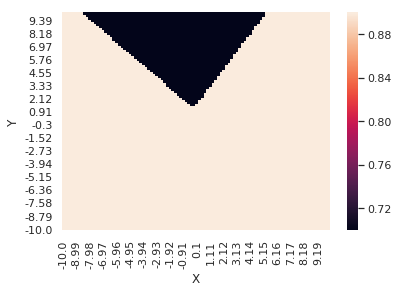

Return recorded for episode113 :  4432.559540016452
0.11126136464838206


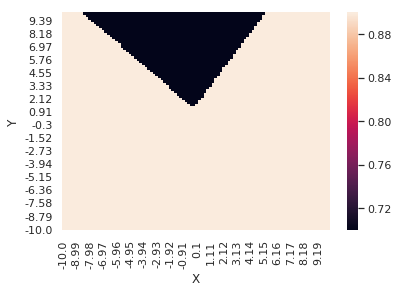

Return recorded for episode114 :  4470.576351909941
0.10925625528557566


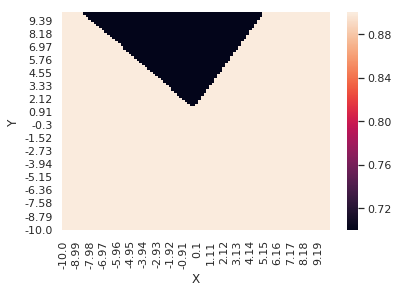

Return recorded for episode115 :  4503.172676288824
0.10729084974831793


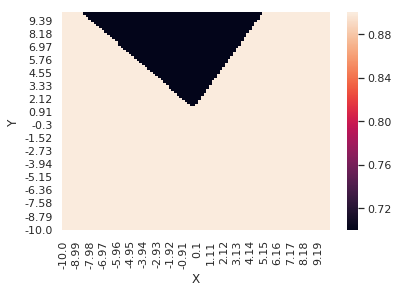

Return recorded for episode116 :  4562.352404315804
0.10536436184818809


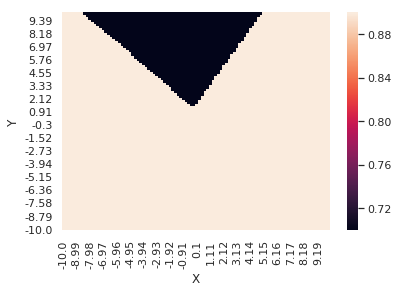

Return recorded for episode117 :  4530.304006580406
0.10347602096433932


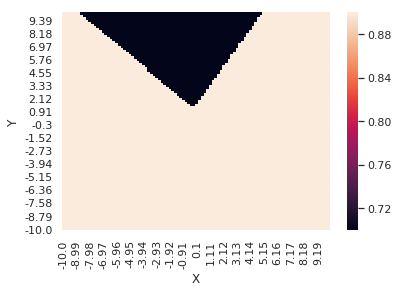

Return recorded for episode118 :  4626.584512927476
0.10162507173523985


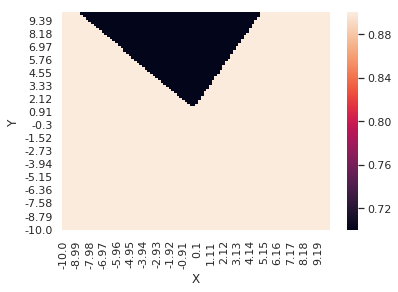

Return recorded for episode119 :  4507.017063190385
0.09981077375651838


Return recorded for episode120 :  4587.2306270097615
Episode 20 ..120   Avg reward: 4495.317347386307   Epsilon: 0.0998
0.09803240128479247


Return recorded for episode121 :  4531.030273622443
0.09628924294736148


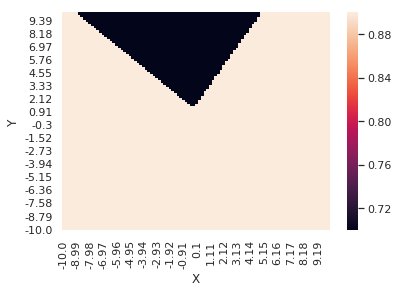

Return recorded for episode122 :  4578.284628184142
0.09458060145764802


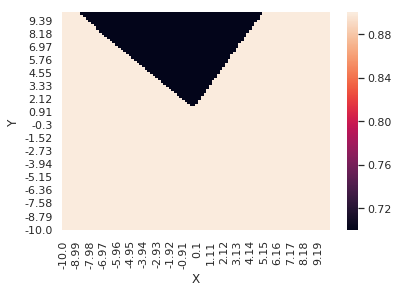

Return recorded for episode123 :  4509.086075309653
0.092905793336274


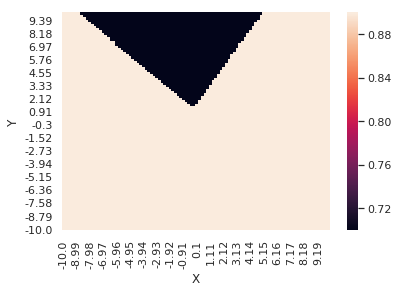

Return recorded for episode124 :  4609.216863728138
0.0912641486376598


Return recorded for episode125 :  4443.726127733475
0.08965501068203711


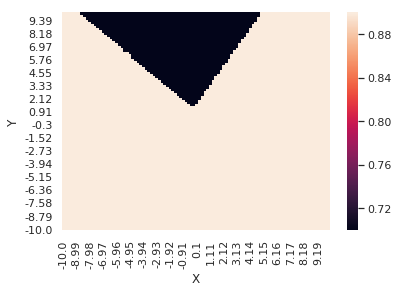

Return recorded for episode126 :  4497.6510202626005
0.08807773579276819


Return recorded for episode127 :  4496.146446879139
0.08653169303886674


Return recorded for episode128 :  4677.795839433267
0.08501626398261702


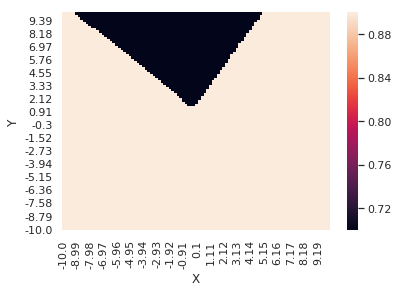

Return recorded for episode129 :  4571.635679767563
0.08353084243219053


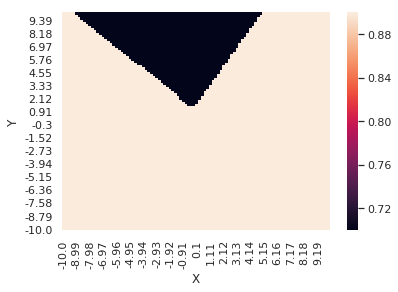

Return recorded for episode130 :  4644.781316610114
Episode 30 ..130   Avg reward: 4550.180358193018   Epsilon: 0.0835
0.08207483419916123


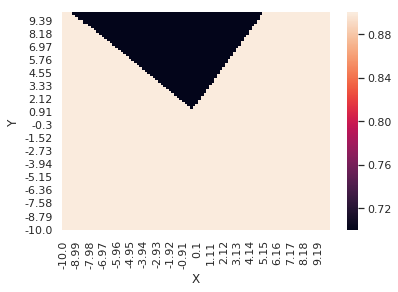

Return recorded for episode131 :  4623.35691847646
0.08064765686082219


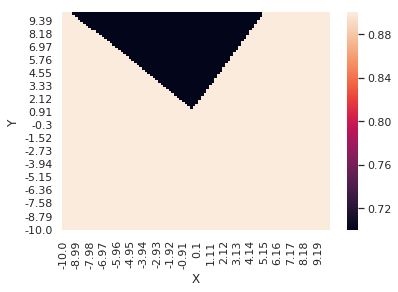

Return recorded for episode132 :  4578.64575492386
0.0792487395272088


Return recorded for episode133 :  4586.358094742723
0.07787752261273513


Return recorded for episode134 :  4516.6320447923335
0.07653345761235225


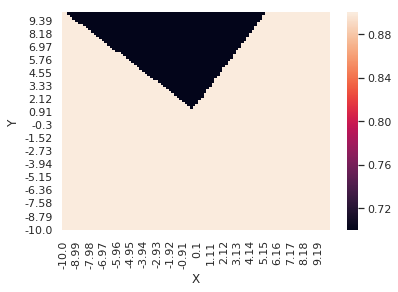

Return recorded for episode135 :  4576.42666008796
0.07521600688213892


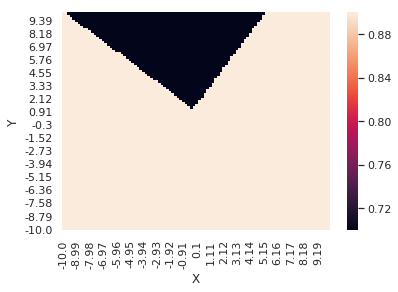

Return recorded for episode136 :  4601.053158711261
0.07392464342423678


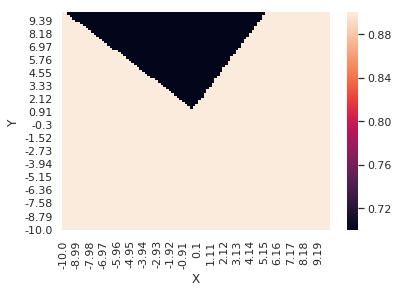

Return recorded for episode137 :  4633.705544213228
0.07265885067604429


Return recorded for episode138 :  4597.324876456166
0.0714181223035847


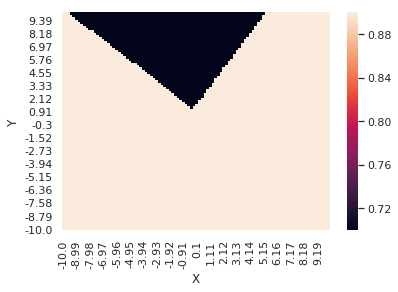

Return recorded for episode139 :  4539.4738505141195
0.07020196199896576


Return recorded for episode140 :  4552.3313137043315
Episode 40 ..140   Avg reward: 4589.775821952822   Epsilon: 0.0702
0.06900988328184997


Return recorded for episode141 :  4562.563133231155
0.06784140930485581


Return recorded for episode142 :  4596.7593144327675
0.06669607266281269


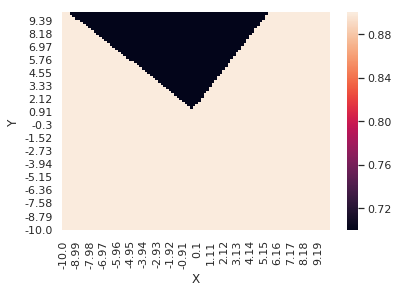

Return recorded for episode143 :  4553.748974174382
0.06557341520579238


Return recorded for episode144 :  4497.792376814118
0.06447298785584316


Return recorded for episode145 :  4605.741220891301
0.06339435042735246


Return recorded for episode146 :  4532.85519217348
0.06233707145096687


Return recorded for episode147 :  4518.138128370787
0.061300728000998575


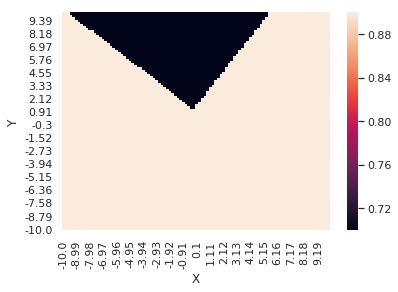

Return recorded for episode148 :  4566.435440268114
0.060284905526249516


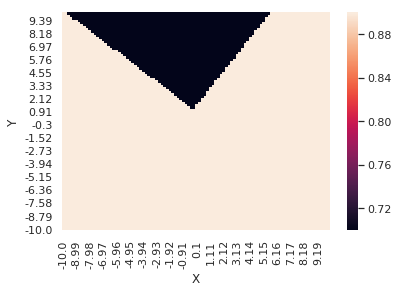

Return recorded for episode149 :  4589.45381394306
0.05928919768418531


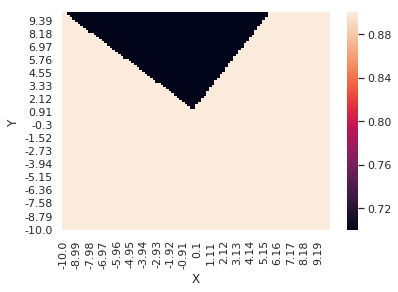

Return recorded for episode150 :  4535.512808272214
Episode 50 ..150   Avg reward: 4557.581890800349   Epsilon: 0.0593
0.058313206178392835


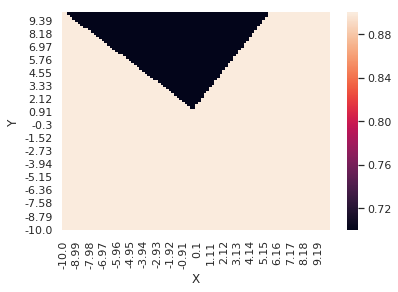

Return recorded for episode151 :  4534.168857887244
0.057356540599256385


Return recorded for episode152 :  4493.338111630641
0.0564188182677886


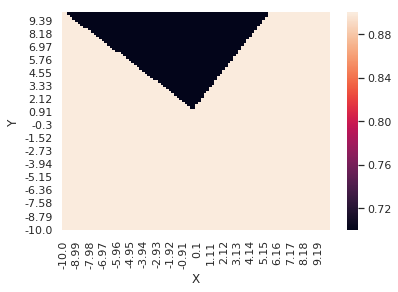

Return recorded for episode153 :  4553.222908936542
0.05549966408255377


Return recorded for episode154 :  4632.76793817183
0.05459871036962222


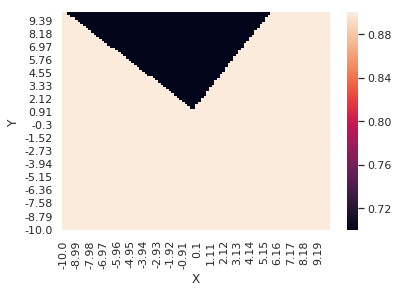

Return recorded for episode155 :  4572.330828353055
0.05371559673549593


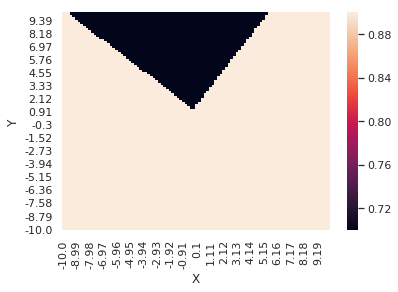

Return recorded for episode156 :  4597.891012166993
0.05284996992294624


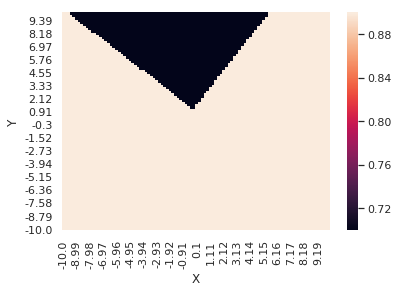

Return recorded for episode157 :  4492.728984179286
0.05200148366970627


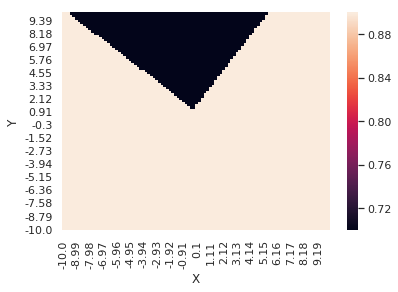

Return recorded for episode158 :  4577.164066278766
0.05116979856996143


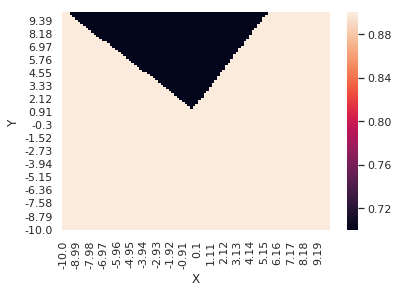

Return recorded for episode159 :  4556.1827381727935
0.05035458193858255


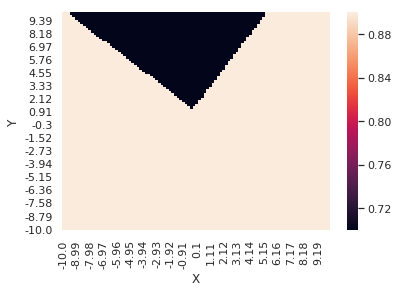

Return recorded for episode160 :  4602.388454955497
Episode 60 ..160   Avg reward: 4554.530825404936   Epsilon: 0.0504
0.04955550767804736


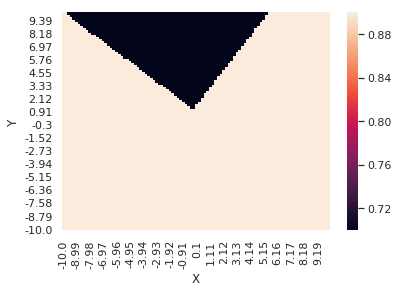

Return recorded for episode161 :  4573.829497623975
0.0487722561479972


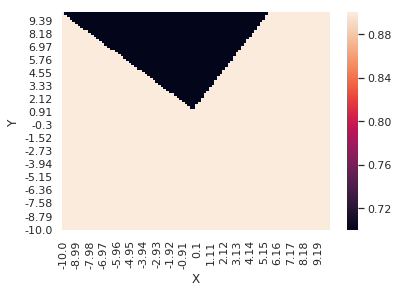

Return recorded for episode162 :  4531.836026876767
0.04800451403737654


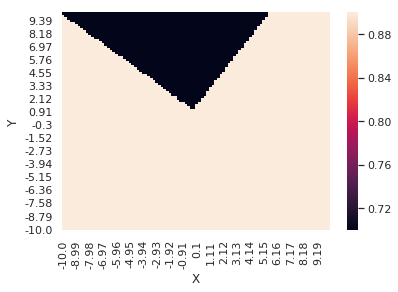

Return recorded for episode163 :  4586.1449905427235
0.04725197423910444


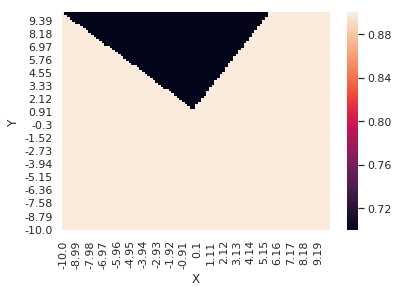

Return recorded for episode164 :  4602.538220854195
0.046514335727227595


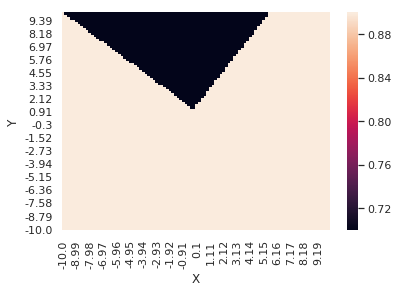

Return recorded for episode165 :  4527.883046539379
0.04579130343650595


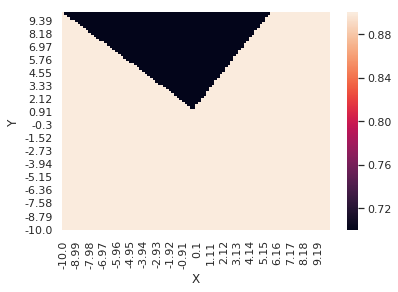

Return recorded for episode166 :  4498.14999478467
0.04508258814438266


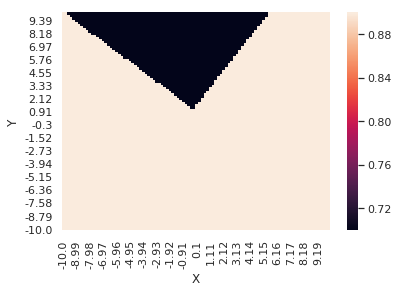

Return recorded for episode167 :  4557.075675916531
0.044387906355291176


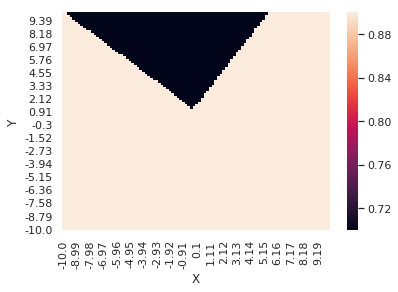

Return recorded for episode168 :  4567.343195113747
0.04370698018725335


Return recorded for episode169 :  4446.835586924362
0.04303953726072282


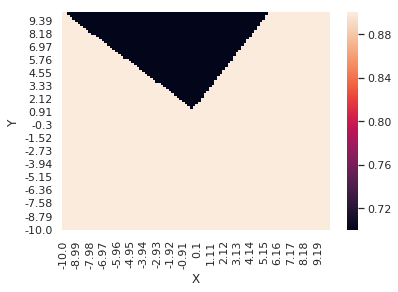

Return recorded for episode170 :  4593.843893700096
Episode 70 ..170   Avg reward: 4549.402469013185   Epsilon: 0.0430
0.042385310589629625


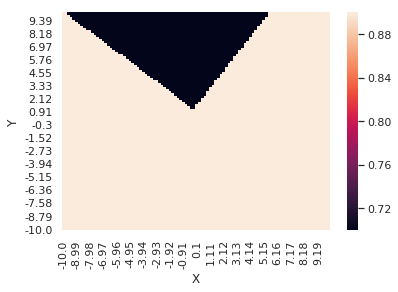

Return recorded for episode171 :  4543.146962756778
0.04174403847458216


Return recorded for episode172 :  4545.701946376539
0.04111546439818403


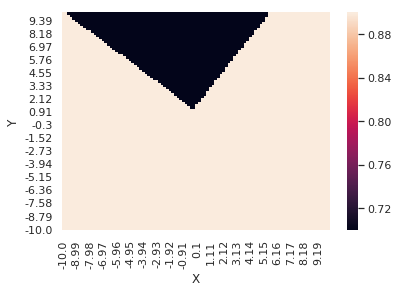

Return recorded for episode173 :  4585.374556824639
0.040499336922423565


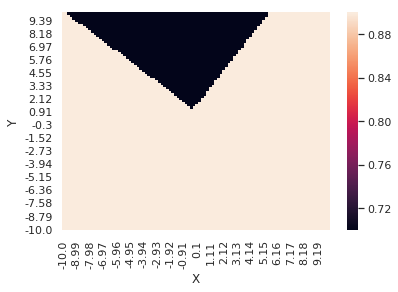

Return recorded for episode174 :  4491.012443214234
0.039895409588095315


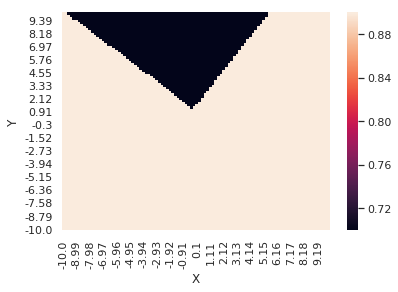

Return recorded for episode175 :  4559.922690876678
0.03930344081621308


Return recorded for episode176 :  4583.85627441995
0.03872319381137508


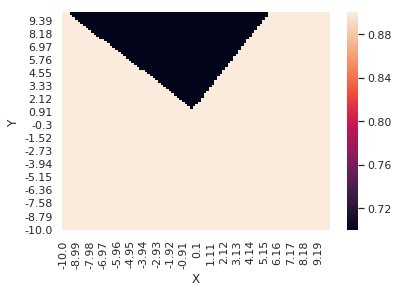

Return recorded for episode177 :  4565.091807025704
0.03815443646704266


Return recorded for episode178 :  4546.894322903875
0.03759694127269454


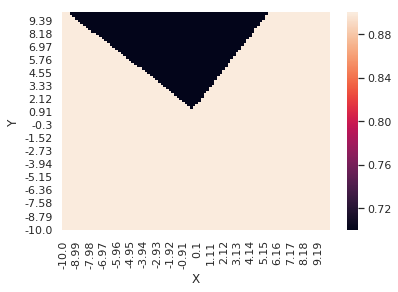

Return recorded for episode179 :  4498.292226695569
0.03705048522281963


Return recorded for episode180 :  4561.761125617269
Episode 80 ..180   Avg reward: 4551.313712479407   Epsilon: 0.0371
0.036514849727711796


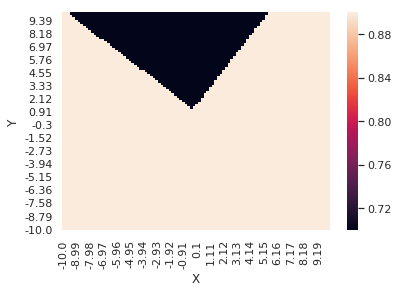

Return recorded for episode181 :  4611.576594545246
0.03598982052603108


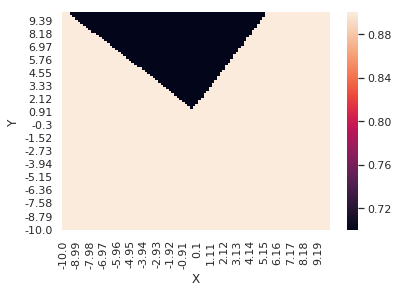

Return recorded for episode182 :  4555.774959190089
0.03547518759909634


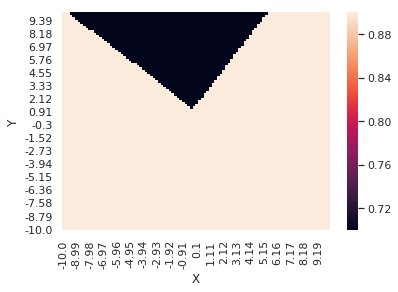

Return recorded for episode183 :  4612.4058512249885
0.03497074508687494


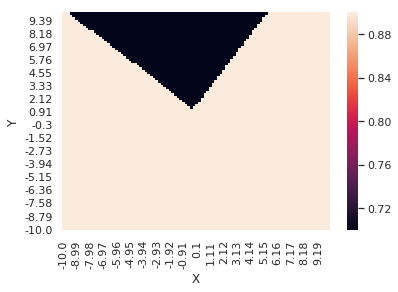

Return recorded for episode184 :  4578.561282227423
0.034476291205635994


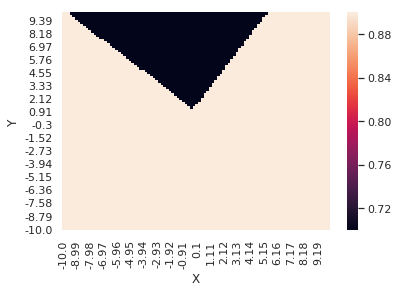

Return recorded for episode185 :  4601.944324012368
0.0339916281672342


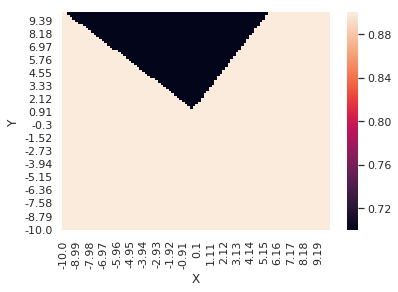

Return recorded for episode186 :  4646.296584031032
0.033516562099991945


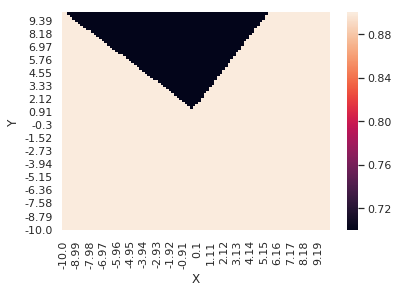

Return recorded for episode187 :  4536.624074445414
0.03305090297114803


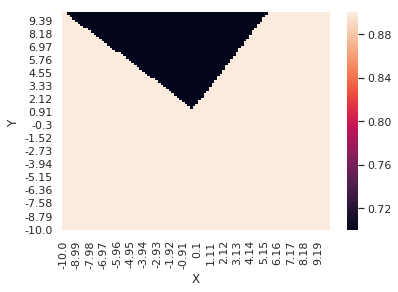

Return recorded for episode188 :  4570.617556863475
0.03259446451084204


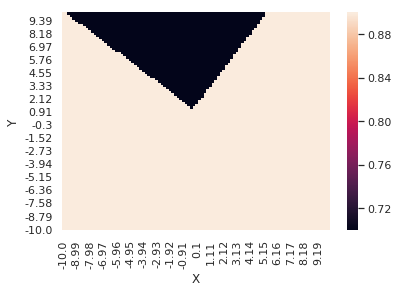

Return recorded for episode189 :  4502.019510286061
0.03214706413760394


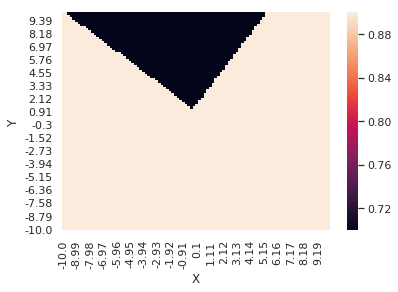

Return recorded for episode190 :  4608.070968788877
Episode 90 ..190   Avg reward: 4577.758186244338   Epsilon: 0.0321
0.031708522885318995


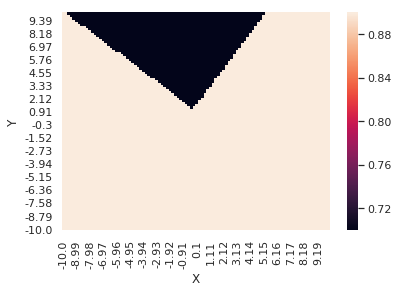

Return recorded for episode191 :  4613.601988598978
0.031278665331639026


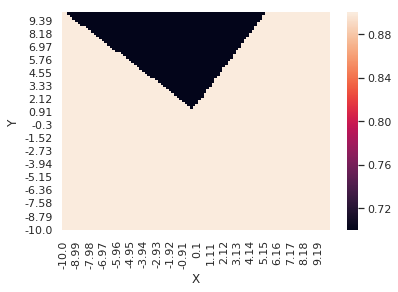

Return recorded for episode192 :  4609.313520627205
0.030857319527811018


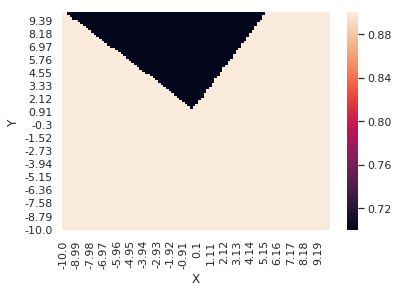

Return recorded for episode193 :  4673.997872079805
0.030444316929895437


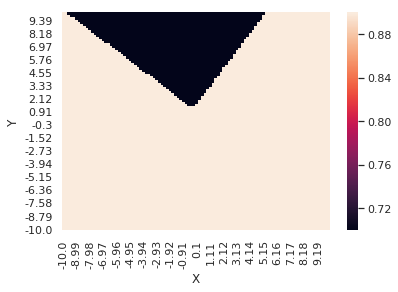

Return recorded for episode194 :  4593.063258709314
0.030039492331346347


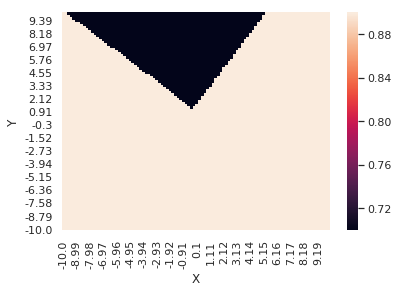

Return recorded for episode195 :  4614.476920035836
0.029642683796926583


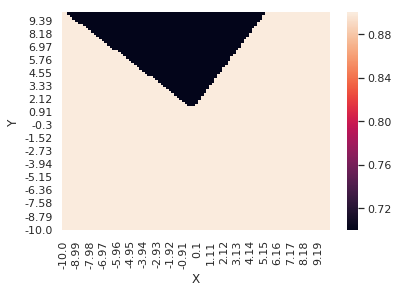

Return recorded for episode196 :  4586.351045699489
0.029253732597931535


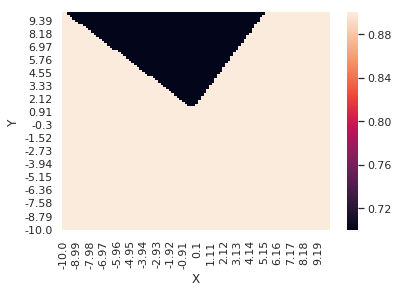

Return recorded for episode197 :  4580.079641543009
0.02887248314869552


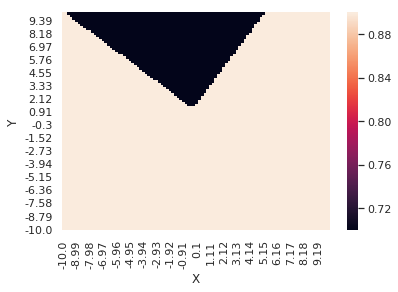

Return recorded for episode198 :  4656.332508554714
0.02849878294435545


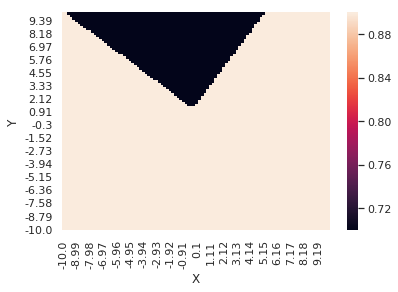

Return recorded for episode199 :  4625.2064808606965
0.028132482499846838


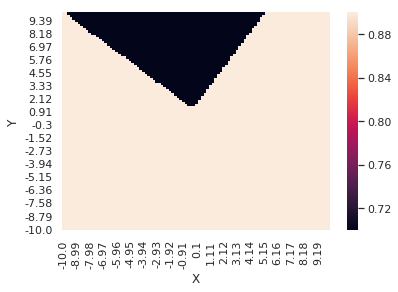

Return recorded for episode200 :  4561.1120016868645
Episode 100 ..200   Avg reward: 4616.049420549792   Epsilon: 0.0281
0.02777343529010782


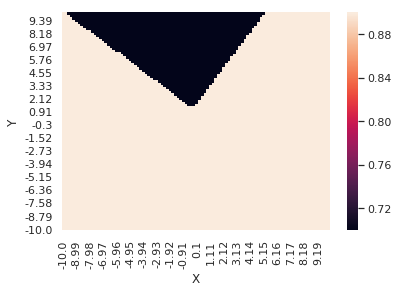

Return recorded for episode201 :  4667.662986456513
0.027421497691467157


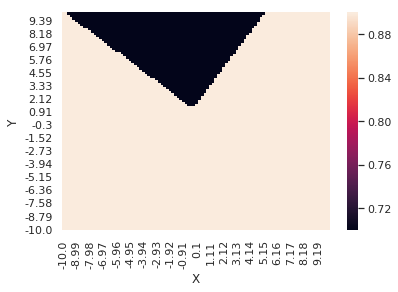

Return recorded for episode202 :  4601.950395859392
0.0270765289241928


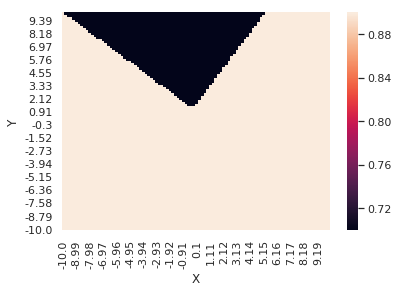

Return recorded for episode203 :  4664.886465371888
0.026738390996178224


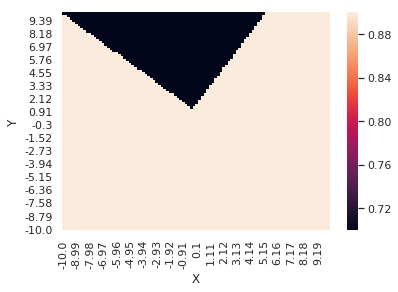

Return recorded for episode204 :  4642.946098428936
0.026406948647743643


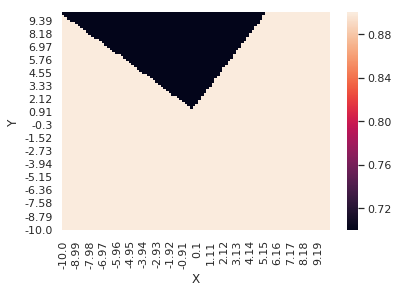

Return recorded for episode205 :  4585.468639351768
0.026082069297530375


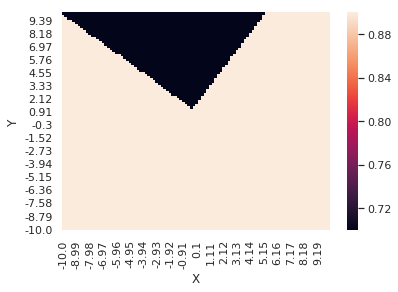

Return recorded for episode206 :  4681.968213468021
0.025763622989466578


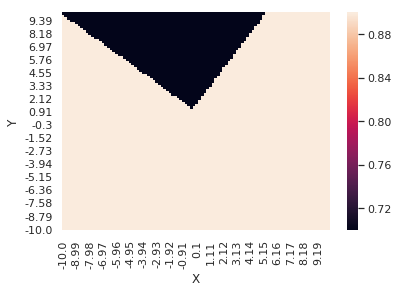

Return recorded for episode207 :  4591.632634808825
0.025451482340783003


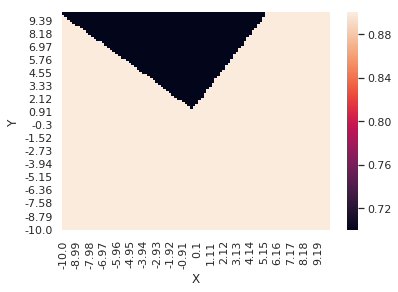

Return recorded for episode208 :  4593.09353786874
0.025145522491058264


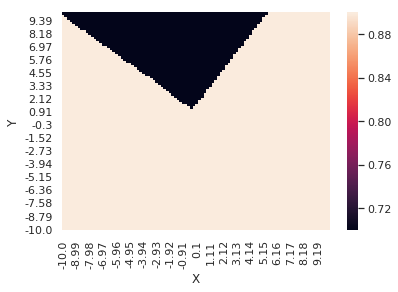

Return recorded for episode209 :  4633.653406846389
0.024845621052272927


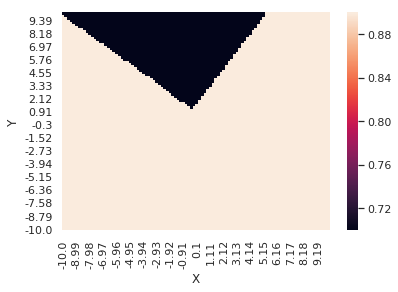

Return recorded for episode210 :  4631.132631420071
Episode 110 ..210   Avg reward: 4622.437438014734   Epsilon: 0.0248
0.024551658059852766


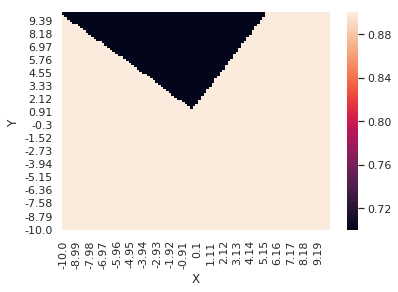

Return recorded for episode211 :  4651.004008473767
0.024263515924681227


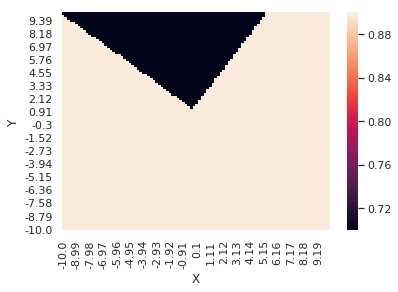

Return recorded for episode212 :  4637.464852837235
0.023981079386062323


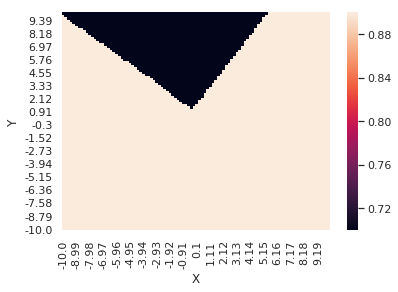

Return recorded for episode213 :  4622.397079179501
0.023704235465614704


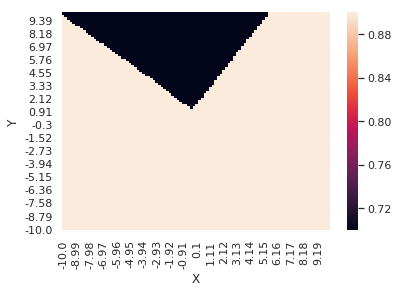

Return recorded for episode214 :  4573.628166261648
0.023432873422078924


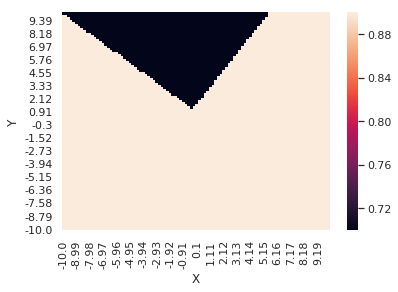

Return recorded for episode215 :  4568.377626846464
0.02316688470701933


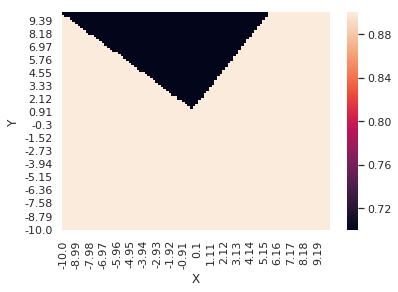

Return recorded for episode216 :  4612.234224246934
0.022906162921403357


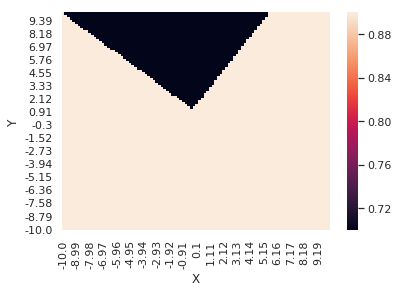

Return recorded for episode217 :  4631.819959803698
0.0226506037730404


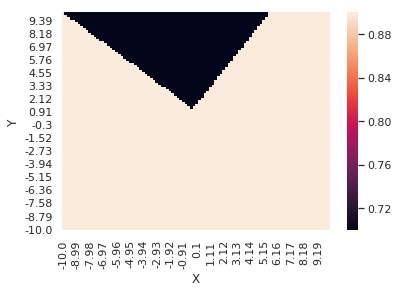

Return recorded for episode218 :  4615.358392346862
0.022400105034863643


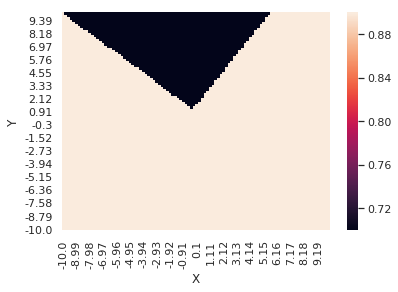

Return recorded for episode219 :  4577.058482350514
0.02215456650403775


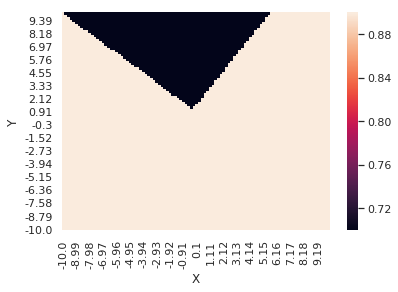

Return recorded for episode220 :  4530.956968394232
Episode 120 ..220   Avg reward: 4612.047542376669   Epsilon: 0.0222
0.021913889961876536


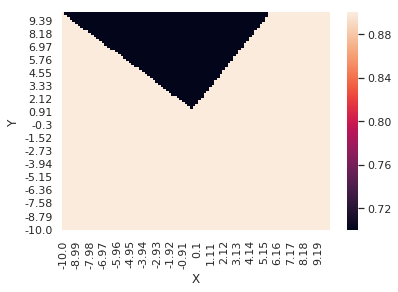

Return recorded for episode221 :  4603.873431644063
0.02167797913455405


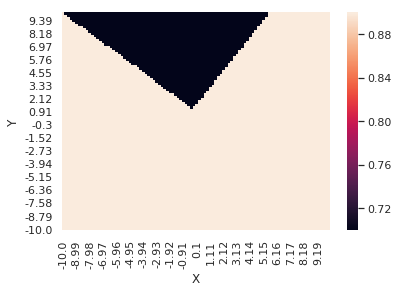

Return recorded for episode222 :  4597.342343687208
0.02144673965459385


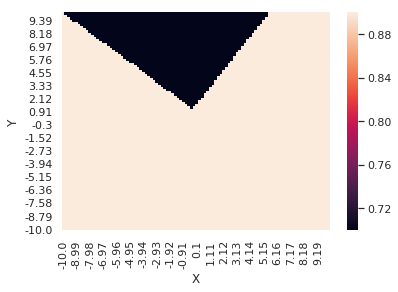

Return recorded for episode223 :  4556.405037552249
0.021220079023120713


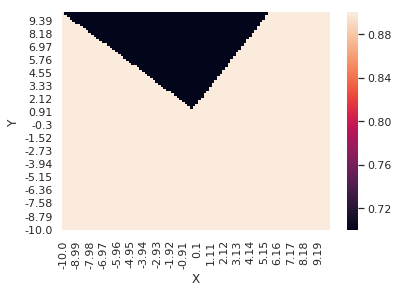

Return recorded for episode224 :  4674.654899580195
0.02099790657285988


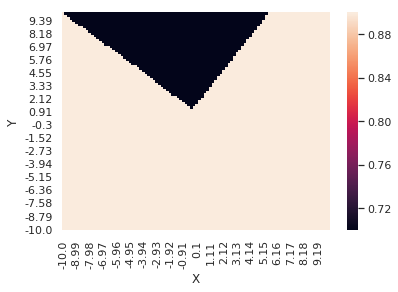

Return recorded for episode225 :  4598.164796793434
0.020780133431868894


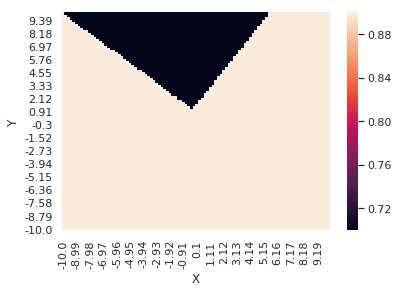

Return recorded for episode226 :  4619.947871430535
0.020566672487987697


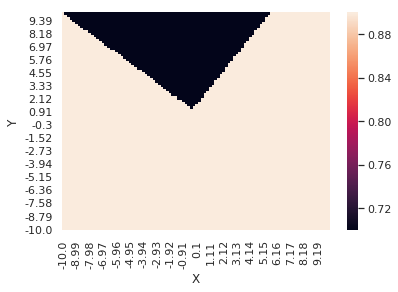

Return recorded for episode227 :  4607.33741863469
0.02035743835399253


Return recorded for episode228 :  4605.199895568083
0.02015234733343998


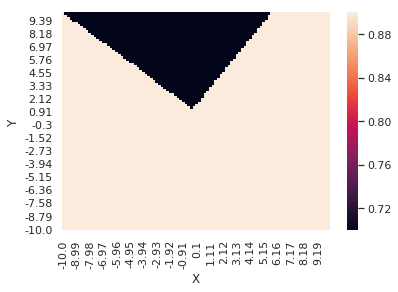

Return recorded for episode229 :  4570.924759044244
0.01995131738718724


Return recorded for episode230 :  4576.74177939324
Episode 130 ..230   Avg reward: 4596.480742232894   Epsilon: 0.0200
0.019754268100575387


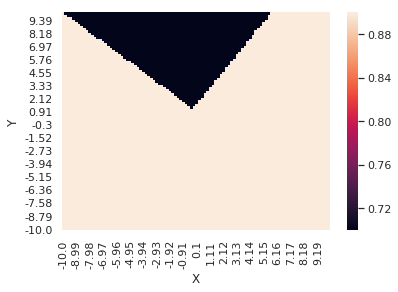

Return recorded for episode231 :  4566.458406878938
0.0195611206512624


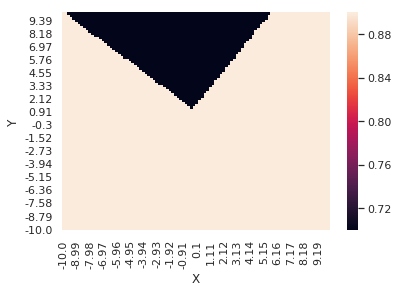

Return recorded for episode232 :  4592.698752556989
0.01937179777769322


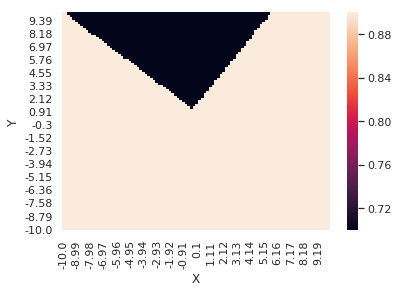

Return recorded for episode233 :  4600.459491189019
0.019186223748194096


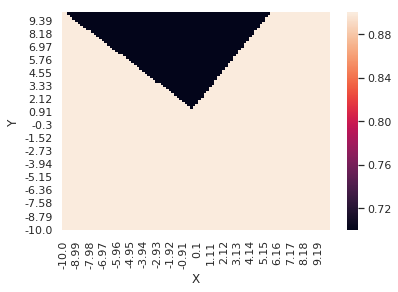

Return recorded for episode234 :  4657.635274127479
0.019004324330678855


Return recorded for episode235 :  4582.166112850774
0.01882602676295516


Return recorded for episode236 :  4600.984859088286
0.018651259723618557


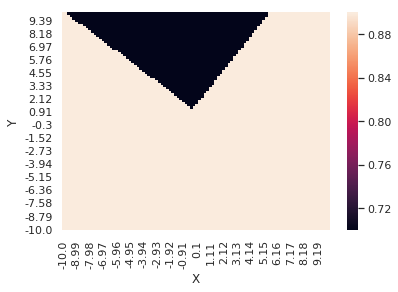

Return recorded for episode237 :  4583.634129758545
0.018479953303523082


Return recorded for episode238 :  4578.092871613693
0.018312038977816556


Return recorded for episode239 :  4558.516156488439
0.01814744957852983


Return recorded for episode240 :  4558.412030651176
Episode 140 ..240   Avg reward: 4589.73878339454   Epsilon: 0.0181
0.01798611926770862


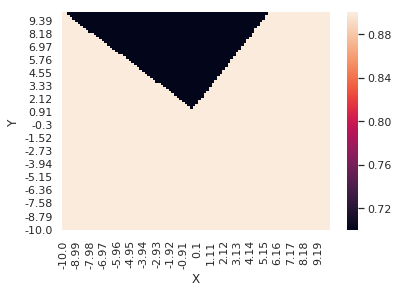

Return recorded for episode241 :  4596.99835426411
0.017827983511077505


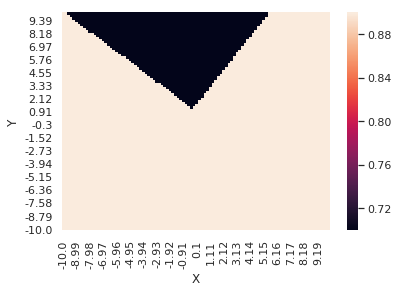

Return recorded for episode242 :  4546.128389873177
0.017672979052225327


Return recorded for episode243 :  4624.523723665911
0.01752104388730179


Return recorded for episode244 :  4575.125981024484
0.017372117240215094


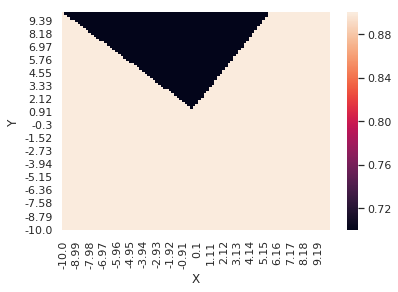

Return recorded for episode245 :  4577.121972660919
0.0172261395383207


Return recorded for episode246 :  4571.931044432892
0.017083052388591435


Return recorded for episode247 :  4583.461830247886
0.01694279855425957


Return recorded for episode248 :  4582.32242724473
0.016805321931921285


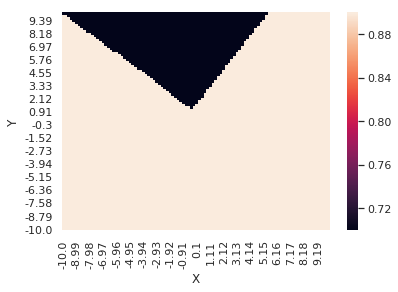

Return recorded for episode249 :  4615.017581237559
0.016670567529094613


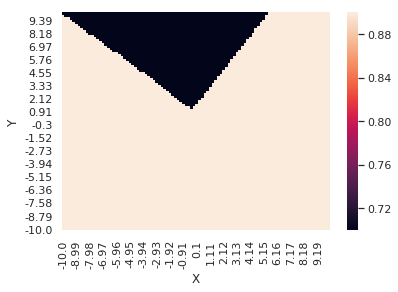

Return recorded for episode250 :  4565.942380540706
Episode 150 ..250   Avg reward: 4583.104333530284   Epsilon: 0.0167
0.016538481442221656


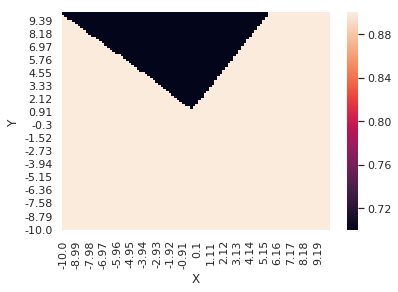

Return recorded for episode251 :  4604.372354468781
0.01640901083510651


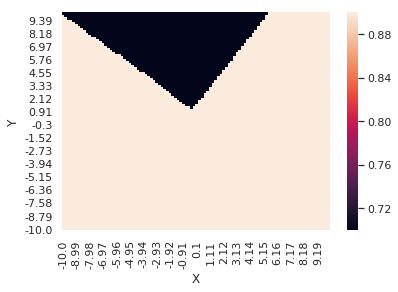

Return recorded for episode252 :  4632.158685894789
0.016282103917780018


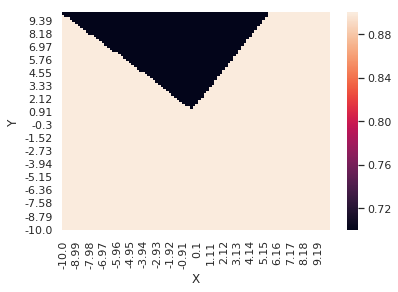

Return recorded for episode253 :  4624.3945657616405
0.016157709925783147


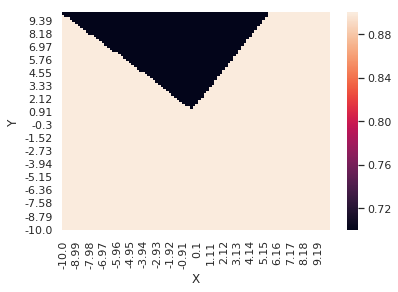

Return recorded for episode254 :  4652.190094891636
0.016035779099860478


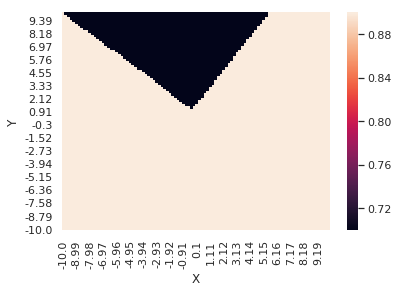

Return recorded for episode255 :  4572.430440604202
0.015916262666055885


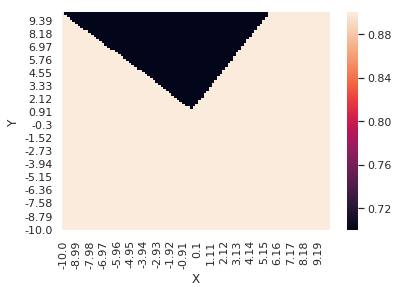

Return recorded for episode256 :  4574.120496932538
0.015799112816202266


Return recorded for episode257 :  4603.351227622152
0.01568428268879766


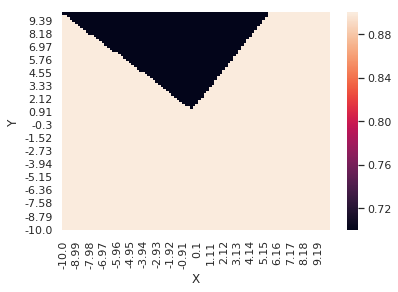

Return recorded for episode258 :  4670.326562983181
0.015571726350260025


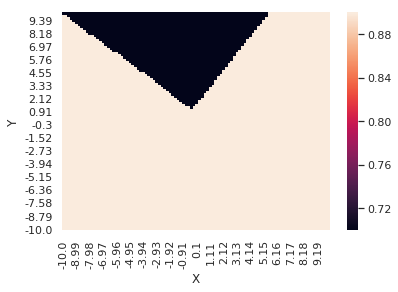

Return recorded for episode259 :  4621.259041057991
0.015461398776553163


Return recorded for episode260 :  4639.990399144458
Episode 160 ..260   Avg reward: 4612.054585075762   Epsilon: 0.0155
0.01535325583517655


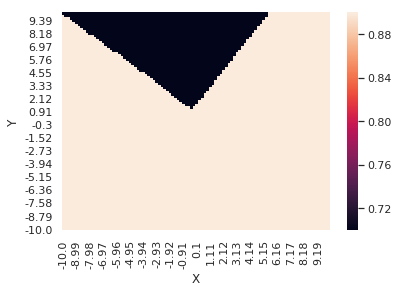

Return recorded for episode261 :  4560.580431821052
0.015247254267511699


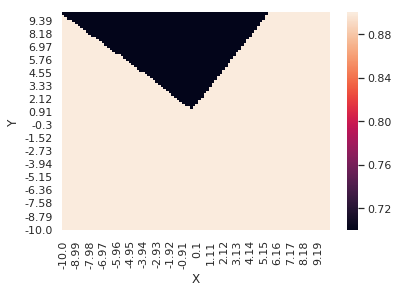

Return recorded for episode262 :  4607.116533221143
0.015143351671518179


Return recorded for episode263 :  4622.910034283779
0.015041506484772198


Return recorded for episode264 :  4599.407290768207
0.014941677967841115


Return recorded for episode265 :  4564.905095565537
0.014843826187987082


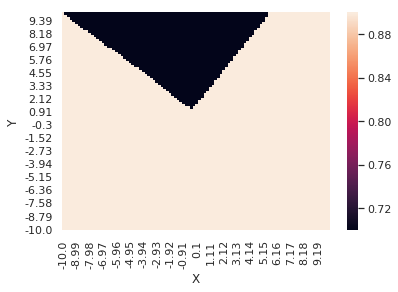

Return recorded for episode266 :  4653.509740454351
0.014747912003193458


Return recorded for episode267 :  4571.068204082921
0.014653897046507443


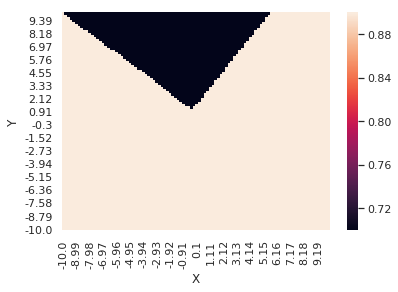

Return recorded for episode268 :  4600.848944838778
0.014561743710692824


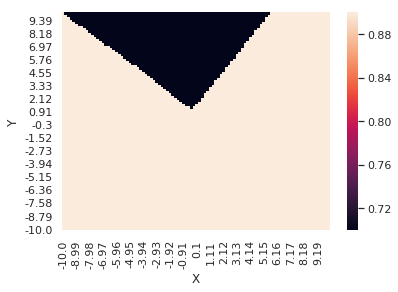

Return recorded for episode269 :  4573.403736323631
0.01447141513318654


Return recorded for episode270 :  4560.895399979442
Episode 170 ..270   Avg reward: 4599.374041050386   Epsilon: 0.0145
0.014382875181353196


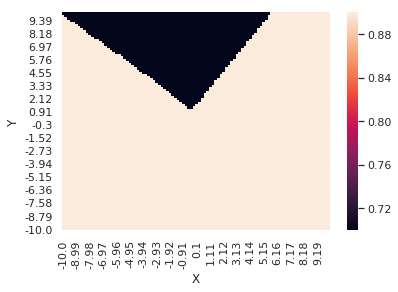

Return recorded for episode271 :  4597.016780638092
0.014296088438031505


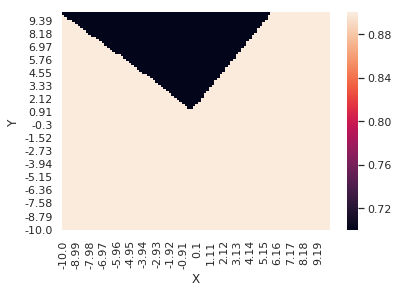

Return recorded for episode272 :  4595.576473312518
0.014211020187366974


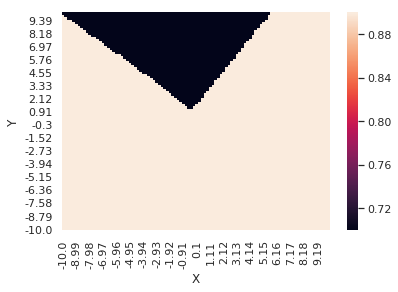

Return recorded for episode273 :  4540.34007668926
0.01412763640092507


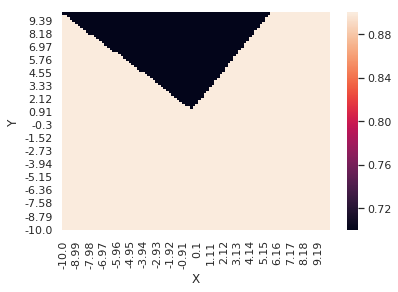

Return recorded for episode274 :  4670.956474749918
0.014045903724079427


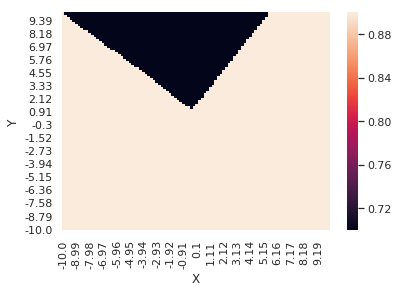

Return recorded for episode275 :  4629.612304130146
0.013965789462669513


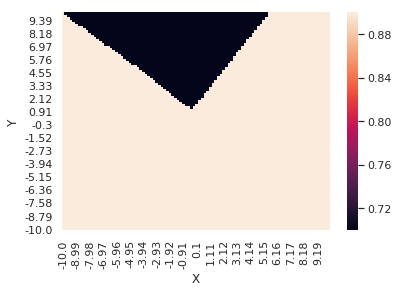

Return recorded for episode276 :  4689.0517939249075
0.013887261569922569


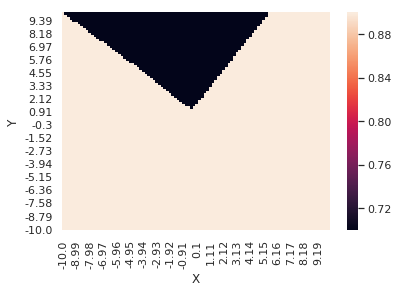

Return recorded for episode277 :  4709.05690374679
0.013810288633634434


Return recorded for episode278 :  4762.098620041954
0.013734839863604284


Return recorded for episode279 :  4772.553669452493
0.0136608850793181


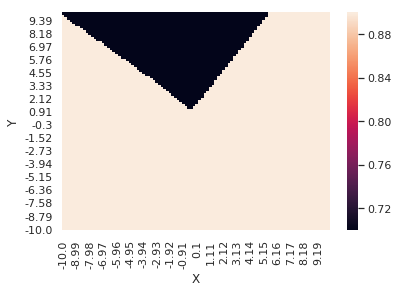

Return recorded for episode280 :  4690.936284058425
Episode 180 ..280   Avg reward: 4652.7158496665525   Epsilon: 0.0137
0.013588394697876097


Return recorded for episode281 :  4678.599943617793
0.013517339722159148


Return recorded for episode282 :  4685.520194328465
0.013447691729229546


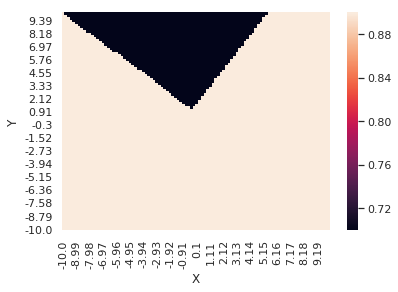

Return recorded for episode283 :  4683.863995855088
0.013379422858961477


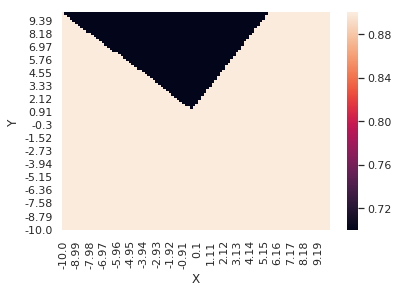

Return recorded for episode284 :  4725.286378803184
0.01331250580289656


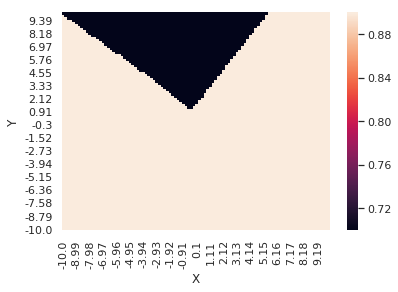

Return recorded for episode285 :  4740.3880302160005
0.013246913793320138


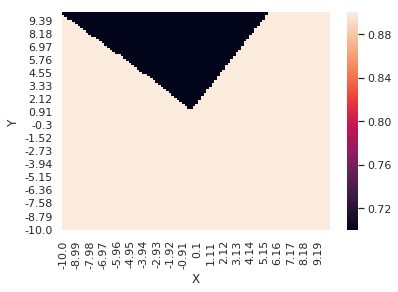

Return recorded for episode286 :  4702.444270514295
0.013182620592553802


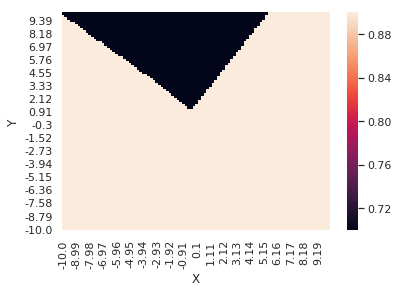

Return recorded for episode287 :  4707.474942714523
0.013119600482459998


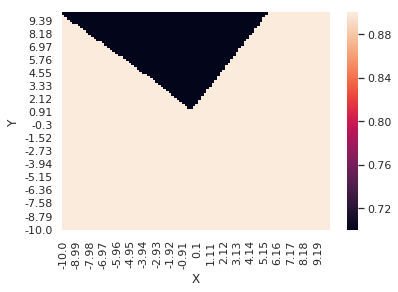

Return recorded for episode288 :  4772.563048159262
0.013057828254154401


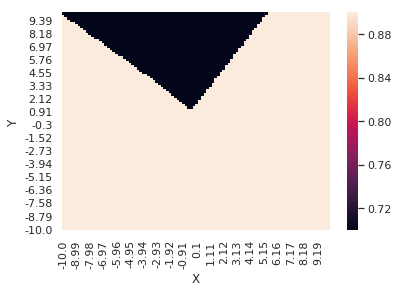

Return recorded for episode289 :  4746.527840169827
0.012997279197922058


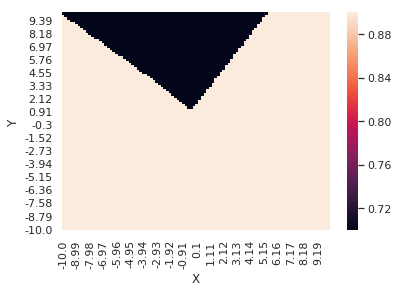

Return recorded for episode290 :  4755.312152591465
Episode 190 ..290   Avg reward: 4713.360492843686   Epsilon: 0.0130
0.012937929093333135


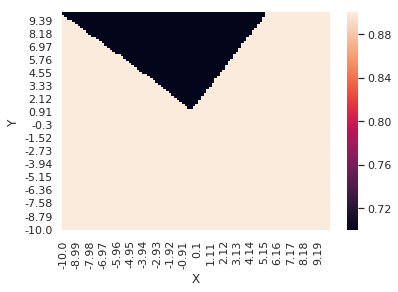

Return recorded for episode291 :  4684.444273598083
0.012879754199554458


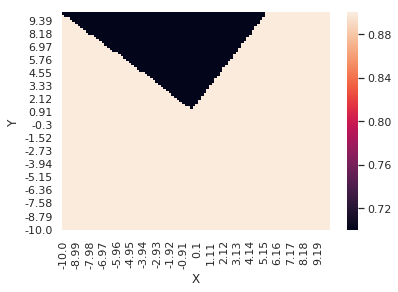

Return recorded for episode292 :  4720.624823256225
0.012822731245852837


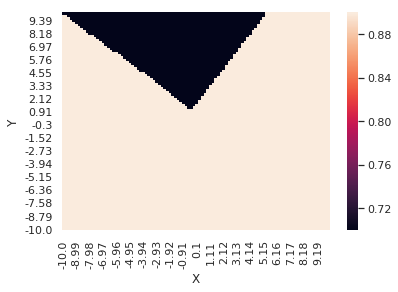

Return recorded for episode293 :  4761.792037108373
0.012766837422286476


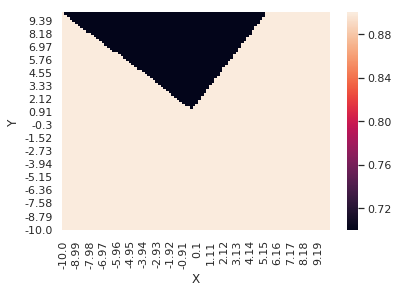

Return recorded for episode294 :  4713.876767278741
0.012712050370580685


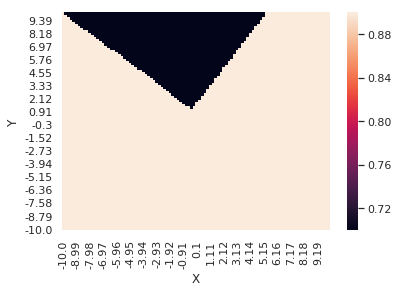

Return recorded for episode295 :  4696.773015182742
0.012658348175184284


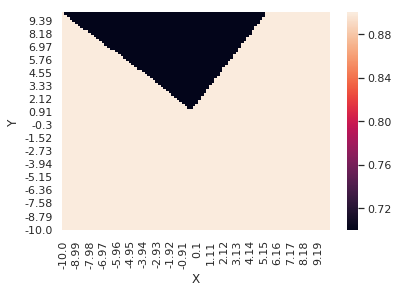

Return recorded for episode296 :  4676.622879653854
0.012605709354503067


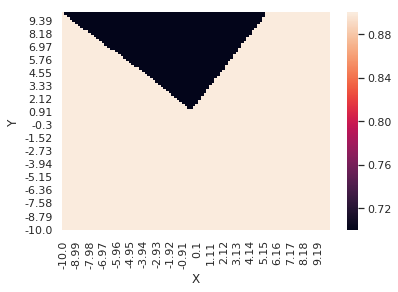

Return recorded for episode297 :  4725.384462388209
0.012554112852306908


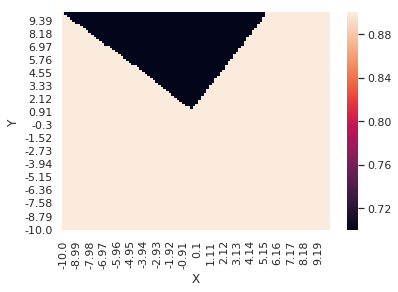

Return recorded for episode298 :  4704.37162624896
0.012503538029306963


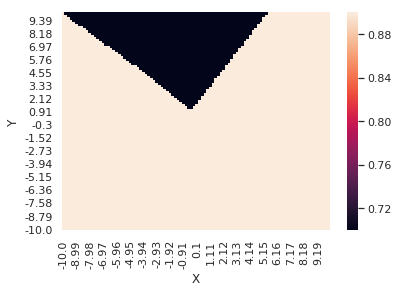

Return recorded for episode299 :  4703.539124667491
0.012453964654899695


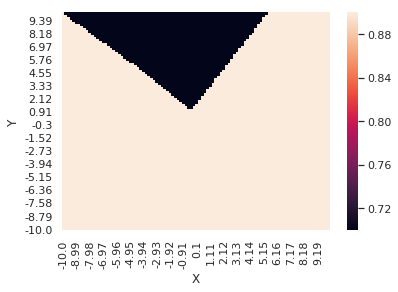

Return recorded for episode300 :  4625.211450687946
Episode 200 ..300   Avg reward: 4714.2741161974145   Epsilon: 0.0125
0.01240537289907435


KeyboardInterrupt: 

In [7]:
# Exploration parameters
min_epsilon = 0.01
# epsilon = 0.99            # minimum exploration probability
decay_rate = 20/NUM_EPISODES
returns = np.zeros(NUM_EPISODES)

# env.monitor.start(logdir, force=True)

for ep in range(1, NUM_EPISODES):
    # Start new episode
    state = env.reset()
#     state = env.env.env.hard_reset()
    state = np.reshape(state, [1, state.size])
#     print('state', state.shape)

    total_reward = 0
    episode_step = 0
    done = False

    epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
#     epsilon *= decay_rate
    print(epsilon)
    while not done:
        episode_step += 1
#         epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
        action = DQN.action_sampler(state, epsilon)
        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)

        next_state = np.reshape(next_state, [1, state.size])

        total_reward += reward
        #add to replay buffer
        DQN.replay_buffer.push(state, action, reward, next_state, done)
#         print(reward)
        state = next_state
    



    # Progress updates
    returns[ep]=total_reward

    ax = action_heatmap.main(env, DQN.mainDQN)
    fig = ax.get_figure()
    fig.savefig('./heatmaps/action_heatmap_ep_' + str(ep) +'.png')
    
    print('Return recorded for episode ' + str(ep) + ' : ', total_reward)

    # record episodes
    if ep % 10 == 0: env.render()
        
    if ep%10 == 0 or ep==NUM_EPISODES-1: #print out gradual improvement
        print('Episode {}'.format(ep-100),'..{}'.format(ep),'  Avg reward: {}'.format(sum(returns[ep-10:ep])/10),'  Epsilon: {:.4f}'.format(epsilon))
    
    if len(DQN.replay_buffer) >= learn_start:
        DQN.train()



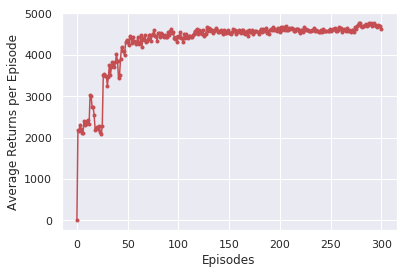

In [8]:
#%% plot average returns
returns_over_each_episode = []
x = []
for i in range(ep):
    returns_over_each_episode.append(sum(returns[1*i:1*(i+1)-1])/1)
    x.append((i+1)*1)
plt.plot(returns[:ep], '.-r')
plt.ylabel('Average Returns per Episode')
plt.xlabel('Episodes')
plt.show()
    

In [ ]:
import importlib
importlib.reload(action_heatmap)
ax = action_heatmap.main(env, DQN.mainDQN)
fig = ax.get_figure()
fig.savefig('./heatmaps/action_heatmap_ep_' + str(ep) +'.png')


In [ ]:
 %matplotlib qt
import reward_surface
import importlib
importlib.reload(reward_surface)
ax = reward_surface.main(env)
fig = ax.get_figure()